# 데이터 불러오기

In [249]:
### 필요한 라이브러리 임폴트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [250]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [251]:
plt.rc('font', family='NanumBarunGothic')

In [252]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/KDT/본 프로젝트'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/KDT/본 프로젝트


In [253]:
### pandas read_csv()함수를 이용, 데이터 셋 생성하기
df = pd.read_csv('0727_Seoul_preprocessed.csv', encoding = 'cp949', index_col=0)

# 결과 확인
print(df.head())
print('='*100)
print(df.tail())
print('='*100)
print(df.info())

   기준_년_코드  기준_분기_코드   자치구    행정동  대분류    상권_코드    중분류         업종명  총_점포수  \
0     2022         1  서대문구  북가좌2동  서비스  2110499     의료         한의원      1   
1     2022         1   노원구   공릉1동   소매  2110433  의류/잡화          안경      1   
2     2022         1   마포구   성산1동   소매  2110548   전자기기  컴퓨터및주변장치판매      4   
3     2022         1   은평구    대조동  서비스  2110481     미용       피부관리실      3   
4     2022         1  영등포구   신길6동  서비스  2110804     교육        예술학원      5   

   점포_수  ...  개업_점포_수  폐업_률  폐업_점포_수  프랜차이즈_점포_수   총_매출_금액  분기당_매출_금액  \
0     1  ...        0     0        0           0  54003138   54003138   
1     1  ...        0     0        0           0  16150022   16150022   
2     4  ...        0     0        0           0  89813767   89813767   
3     3  ...        1     0        0           0   4619842    4619842   
4     5  ...        0     0        0           0   5946480    5946480   

   주중_매출_금액  주말_매출_금액  남성_매출_금액  여성_매출_금액  
0  35504845  18498293   8791373  45211765  
1  1467465

In [254]:
# 이런저런 전처리

# 컬럼명 바꾸기
df = df.rename(columns = {'남성_매출_금액' : '남성매출금액',
                          '여성_매출_금액' : '여성매출금액',
                          '점포_수' : '점포수',
                          '총_점포수' : '총 점포수',
                          '개업_점포_수' : '개업점포수',
                          '폐업_점포_수' : '폐업점포수',
                          '프랜차이즈_점포_수' : '프랜차이즈 수',
                          '개업_율' : '개업률',
                          '폐업_률' : '폐업률'})

# df에 분기, 상반기/하반기 추가
df['분기'] = df['기준_년_코드'].astype(str) + '-' + df['기준_분기_코드'].astype(str)

df.columns

Index(['기준_년_코드', '기준_분기_코드', '자치구', '행정동', '대분류', '상권_코드', '중분류', '업종명',
       '총 점포수', '점포수', '순점포증감률', '개업률', '개업점포수', '폐업률', '폐업점포수', '프랜차이즈 수',
       '총_매출_금액', '분기당_매출_금액', '주중_매출_금액', '주말_매출_금액', '남성매출금액', '여성매출금액',
       '분기'],
      dtype='object')

In [255]:
# 분기별 내림차순 정렬
df = df.sort_values(by=['기준_년_코드', '기준_분기_코드'], ascending=True).reset_index().drop('index', axis=1)
# df

In [256]:
# 신촌동만 남김
df_sin = df[df.행정동=='신촌동']

# 신촌동에 중분류 업종 중 '주유', '여행', '기술', '정비/수리' 는 18년도에만 매출이 찍혀있으므로, 제외하도록 하자.
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '주유'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '여행'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '기술'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '정비/수리'].index).reset_index().drop('index', axis=1)

# df_sin

In [257]:
# 분기별 업종별 매출금액 합치기

df_sin_quarter = df_sin.groupby(['분기', '대분류', '중분류', '업종명', '행정동'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()


# # 소매 카테고리만 남기기
# df_sin_sell_quarter = df_sin_quarter[df_sin_quarter.대분류 == '소매'].reset_index().drop('index', axis=1)


# # 서비스 카테고리만 남기기
# df_sin_service_quarter = df_sin_quarter[df_sin_quarter.대분류 == '서비스'].reset_index().drop('index', axis=1)


# # 외식 카테고리만 남기기
# df_sin_food_quarter = df_sin_quarter[df_sin_quarter.대분류 == '외식'].reset_index().drop('index', axis=1)

# # df_sin_food_quarter

# 편의점

In [258]:
# 편의점만 남기기
sin_conv = df_sin_quarter[df_sin_quarter.업종명 == '편의점'].reset_index().drop('index', axis=1)
sin_conv

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,소매,마트,편의점,신촌동,15090165444,81,1,0
1,2017-2,소매,마트,편의점,신촌동,16568229263,84,7,4
2,2017-3,소매,마트,편의점,신촌동,17310811266,83,4,5
3,2017-4,소매,마트,편의점,신촌동,15674109984,82,2,3
4,2018-1,소매,마트,편의점,신촌동,14781832109,79,1,4
5,2018-2,소매,마트,편의점,신촌동,16465014523,77,0,2
6,2018-3,소매,마트,편의점,신촌동,16439378593,81,7,3
7,2018-4,소매,마트,편의점,신촌동,15433879411,78,2,5
8,2019-1,소매,마트,편의점,신촌동,12376114168,79,2,1
9,2019-2,소매,마트,편의점,신촌동,13273101496,76,3,6


## 지표 만들기 : 성장성, 안정성, 시장성, 순점포증감률 => 안정성 제외

In [259]:
# 기초구역 단위별 선택 업종의 전분기 대비 당기의 매출 증감률을 비교하여 성장 정도를 판단
# 성장성 = 당기 매출액 / 전분기 매출액

# 성장성 추가
# shift() 사용. 참고 : https://seong6496.tistory.com/216

sin_conv['성장성'] = sin_conv['분기당_매출_금액'] / sin_conv['분기당_매출_금액'].shift(1)
# 성장성이 1 이하면 지난분기 대비 이번분기 매출이 줄어든 것. 1 이상이어야 해당 분기 매출 상승.


# # 17년도 1분기 성장성 값은 1로 임의로 정한다. 구할 수가 없어서...
sin_conv['성장성'][0] = 1

sin_conv

<ipython-input-259-0ded2972ddeb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_conv['성장성'][0] = 1


,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수,성장성
0,2017-1,소매,마트,편의점,신촌동,15090165444,81,1,0,1.000000
1,2017-2,소매,마트,편의점,신촌동,16568229263,84,7,4,1.097949
2,2017-3,소매,마트,편의점,신촌동,17310811266,83,4,5,1.044820
3,2017-4,소매,마트,편의점,신촌동,15674109984,82,2,3,0.905452
4,2018-1,소매,마트,편의점,신촌동,14781832109,79,1,4,0.943073
5,2018-2,소매,마트,편의점,신촌동,16465014523,77,0,2,1.113868
6,2018-3,소매,마트,편의점,신촌동,16439378593,81,7,3,0.998443
7,2018-4,소매,마트,편의점,신촌동,15433879411,78,2,5,0.938836
8,2019-1,소매,마트,편의점,신촌동,12376114168,79,2,1,0.801880
9,2019-2,소매,마트,편의점,신촌동,13273101496,76,3,6,1.072477


In [260]:
# 개업률, 폐업률, 순점포증감률 추가

sin_conv['개업률'] = (sin_conv['개업점포수'] / sin_conv['총 점포수']) * 100
sin_conv['폐업률'] = (sin_conv['폐업점포수'] / sin_conv['총 점포수']) * 100
sin_conv['순점포증감률'] = ((sin_conv['개업점포수'] - sin_conv['폐업점포수']) / sin_conv['총 점포수']) * 100

# sin_conv

In [261]:
# # 안정성 추가
# # 점포수 변동의 민감도를 판단하기 위해 기초구역 단위별, 선택 업종의 점포수 변화량을 산출하여 안정 정도를 판단
# # 안정성 = 1 - (폐업 점포수 / 신규 점포수).  신규 점포수는 개업 점포수로 한다.

# sin_food_quarter['안정성'] = 1 - (sin_food_quarter['폐업점포수']/sin_food_quarter['개업점포수'])
# # sin_food_quarter

In [262]:
# 시장성 추가
# 기초구역 단위별 점포당 평균 매출을 시군구의 평균 매출과 비교하여 시군구 평균 대비 시장성을 판단
# 시장성 = (행정동 내 분기 매출액 / 분기 점포수) - (자치구 내 분기 매출액 / 분기 점포수)



################################################################################################################################################################################################

# 자치구 평균 매출을 구하기 위해, 원본 데이터로 잠깐 작업하겠습니다
df_seo = df[df['자치구'] == '서대문구']

# 자치구 분기별 업종별 매출금액 합치기
df_seo_quarter = df_seo.groupby(['분기', '자치구', '대분류', '중분류', '업종명'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()

# 한식만 남기기
seo_conv = df_seo_quarter[df_seo_quarter['업종명'] == '편의점'].reset_index()

################################################################################################################################################################################################

sin_conv['시장성'] = (sin_conv['분기당_매출_금액'] / sin_conv['총 점포수']) - (seo_conv['분기당_매출_금액'] / seo_conv['총 점포수'])

sin_conv = sin_conv[['분기', '업종명','분기당_매출_금액', '성장성', '순점포증감률', '시장성']]
sin_conv

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,편의점,15090165444,1.000000,1.234568,1.323951e+05
1,2017-2,편의점,16568229263,1.097949,3.571429,-1.083172e+07
2,2017-3,편의점,17310811266,1.044820,-1.204819,-7.397627e+06
3,2017-4,편의점,15674109984,0.905452,-1.219512,-3.795571e+06
4,2018-1,편의점,14781832109,0.943073,-3.797468,8.262468e+05
5,2018-2,편의점,16465014523,1.113868,-2.597403,-2.677290e+06
6,2018-3,편의점,16439378593,0.998443,4.938272,-1.167881e+07
7,2018-4,편의점,15433879411,0.938836,-3.846154,-6.290746e+06
8,2019-1,편의점,12376114168,0.801880,1.265823,-8.412306e+06
9,2019-2,편의점,13273101496,1.072477,-3.947368,-2.017622e+06


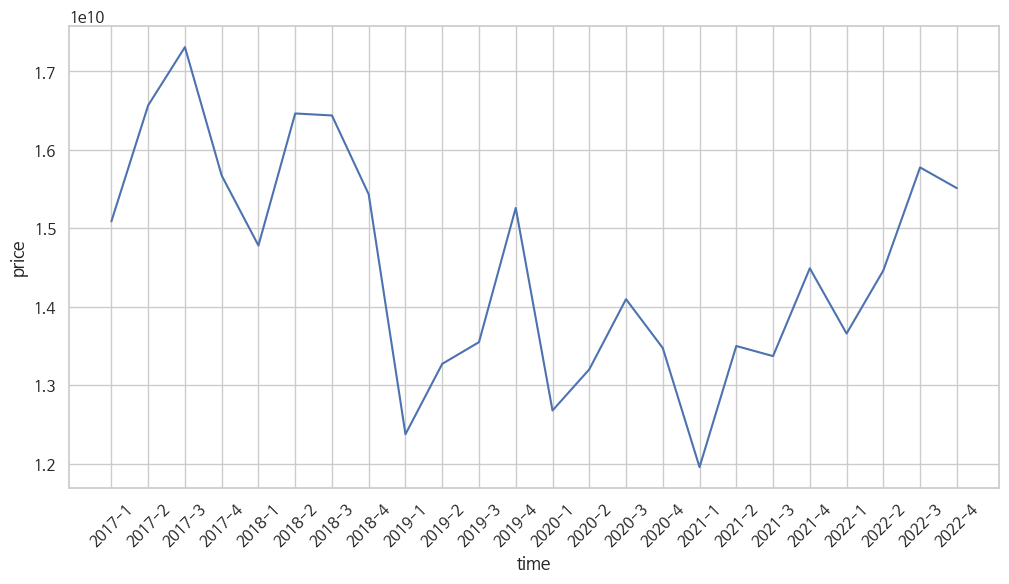

In [263]:
### seaborn lineplot을 이용, 전체 매출 시각화

# 시각화에 필요한 matplotlib.pyplot, seaborn 라이브러리 임폴트
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화
sns.set(style="whitegrid", color_codes=True, font='NanumBarunGothic')

plt.figure(figsize=(12, 6))
sns.lineplot(x=sin_conv['분기'], y=sin_conv['분기당_매출_금액'])
plt.xlabel('time')
plt.xticks(rotation=45)
plt.ylabel('price')
plt.show()

## 23년 1분기 매출 예측

In [264]:
# 총 매출액을 예측하기 위한 지표로는 성장성, 안정성, 시장성, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_conv[['성장성', '시장성', '순점포증감률']]
y = sin_conv.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  1.323951e+05  1.234568
1   1.097949 -1.083172e+07  3.571429
2   1.044820 -7.397627e+06 -1.204819
3   0.905452 -3.795571e+06 -1.219512
4   0.943073  8.262468e+05 -3.797468
5   1.113868 -2.677290e+06 -2.597403
6   0.998443 -1.167881e+07  4.938272
7   0.938836 -6.290746e+06 -3.846154
8   0.801880 -8.412306e+06  1.265823
9   1.072477 -2.017622e+06 -3.947368
10  1.020857 -1.232886e+07  0.000000
11  1.126286  8.366798e+06 -2.631579
12  0.830779 -1.331752e+06 -1.298701
13  1.041332 -7.169836e+06  2.500000
14  1.067797 -4.450322e+06  1.234568
15  0.955822 -6.893093e+06  1.219512
16  0.887361 -1.055772e+06 -5.128205
17  1.129111  1.845858e+06  1.265823
18  0.990444 -7.321959e+05 -1.282051
19  1.083713  1.514778e+07 -2.631579
20  0.942607  1.985382e+07 -2.702703
21  1.058867  1.800774e+07 -1.351351
22  1.090826  2.645425e+07  0.000000
23  0.983232  2.564779e+07  2.631579
---------------------------------------------------------------------------

In [265]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [266]:
### 시계열 분석에 적합한 데이터를 만들어 주는 함수 정의
def make_dataset(X, y, window_size=10):
    X_data = []
    y_data = []
    for start in np.arange(len(X) - window_size):
        stop = start + window_size
        X_data.append(X[start:stop, :])
        y_data.append(y[stop])
    return np.array(X_data), np.array(y_data)




### 시계열 분석에서 마지막 테스트 데이터를 만들어 주는 함수 정의
def make_last_dataset(X, window_size=10):
    X_data_last = []
    for start in np.arange(len(X) - window_size +1):
        stop = start + window_size
        X_data_last.append(X[start:stop, :])
    return X_data_last[-1]

In [267]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (21, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (21, 1)


In [268]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

[[0.78533855 0.78221164 0.37519123]
 [0.88300244 1.         0.50943396]
 [0.55420354 0.97920597 0.77085402]]


In [269]:
### 학습용 / 평가용 데이터 생성

'''
# TEST_SIZE 설정
   (1) TEST_SIZE = 5로 설정
   (2) TEST_SIZE = 5는 가장 최근 5분기의 데이터로 모델이 매출액을 예측
   (3) 학습은 과거부터 5분기 이전의 데이터를 학습
'''

## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (16, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (16, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (16, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (16, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [270]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_41 (LSTM)              (None, 32)                12416     
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [271]:
### 모델 학습

# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.3775
Epoch 1: val_loss improved from inf to 0.08170, saving model to stock_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.3775 - val_loss: 0.0817
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.3766
Epoch 2: val_loss improved from 0.08170 to 0.08124, saving model to stock_model.h5
1/1 [==============================] - 0s 106ms/step - loss: 0.3766 - val_loss: 0.0812
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.3756
Epoch 3: val_loss improved from 0.08124 to 0.08078, saving model to stock_model.h5
1/1 [==============================] - 0s 91ms/step - loss: 0.3756 - val_loss: 0.0808
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.3747
Epoch 4: val_loss improved from 0.08078 to 0.08033, saving model to stock_model.h5
1/1 [==============================] - 0s 95ms/step - loss: 0.3747 - val_loss: 0.0803
Epoch 5/300
1/1 [================

In [272]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 540ms/step
[[0.19421138]
 [0.24760298]
 [0.20042263]
 [0.20066105]
 [0.19788651]]


In [273]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2021-4,0.473353,0.194211
2022-1,0.318003,0.247603
2022-2,0.468199,0.200423
2022-3,0.713577,0.200661
2022-4,0.664163,0.197887


In [274]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_conv의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2021-4,0.473353,0.194211,14491304613,1.299687e+10,1.494438e+09
2022-1,0.318003,0.247603,13659609646,1.328271e+10,3.768991e+08
2022-2,0.468199,0.200423,14463711649,1.303012e+10,1.433591e+09
2022-3,0.713577,0.200661,15777390186,1.303140e+10,2.745993e+09
2022-4,0.664163,0.197887,15512842635,1.301654e+10,2.496299e+09


In [275]:
df_test = df_test.reset_index()

### 결과

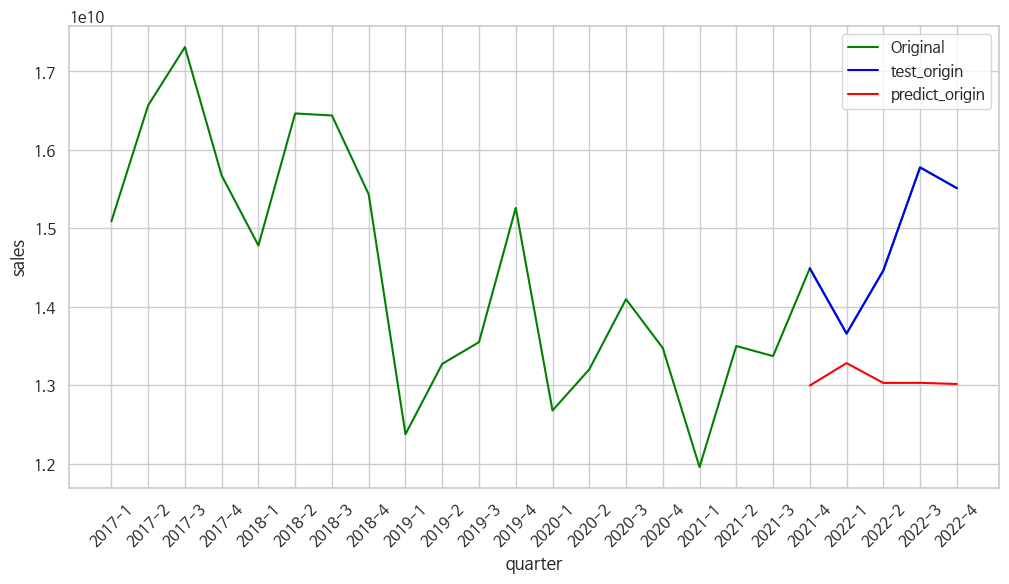

In [276]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [277]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     1.709444e+09
std      9.475723e+08
min      3.768991e+08
25%      1.433591e+09
50%      1.494438e+09
75%      2.496299e+09
max      2.745993e+09
dtype: float64

In [278]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 18ms/step
[[0.2343982]]
--------------------------------------------------------------------------------
예측된 매출  : 13212015616.0 


## 23년 1분기 성장성 예측

In [279]:
# 성장을 예측하기 위한 지표로는 성장성, 안정성, 시장성, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_conv[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_conv.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

      분기당_매출_금액           시장성    순점포증감률
0   15090165444  1.323951e+05  1.234568
1   16568229263 -1.083172e+07  3.571429
2   17310811266 -7.397627e+06 -1.204819
3   15674109984 -3.795571e+06 -1.219512
4   14781832109  8.262468e+05 -3.797468
5   16465014523 -2.677290e+06 -2.597403
6   16439378593 -1.167881e+07  4.938272
7   15433879411 -6.290746e+06 -3.846154
8   12376114168 -8.412306e+06  1.265823
9   13273101496 -2.017622e+06 -3.947368
10  13549942052 -1.232886e+07  0.000000
11  15261108593  8.366798e+06 -2.631579
12  12678606342 -1.331752e+06 -1.298701
13  13202635113 -7.169836e+06  2.500000
14  14097727725 -4.450322e+06  1.234568
15  13474922027 -6.893093e+06  1.219512
16  11957120245 -1.055772e+06 -5.128205
17  13500917234  1.845858e+06  1.265823
18  13371898951 -7.321959e+05 -1.282051
19  14491304613  1.514778e+07 -2.631579
20  13659609646  1.985382e+07 -2.702703
21  14463711649  1.800774e+07 -1.351351
22  15777390186  2.645425e+07  0.000000
23  15512842635  2.564779e+07  2.631579


In [280]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [281]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (21, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (21, 1)


In [282]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

[[0.46819874 0.78221164 0.37519123]
 [0.71357684 1.         0.50943396]
 [0.66416279 0.97920597 0.77085402]]


In [283]:
### 학습용 / 평가용 데이터 생성

'''
# TEST_SIZE 설정
   (1) TEST_SIZE = 5로 설정
   (2) TEST_SIZE = 5는 가장 최근 5분기의 데이터로 모델이 매출액을 예측
   (3) 학습은 과거부터 5분기 이전의 데이터를 학습
'''

## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (16, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (16, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (16, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (16, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [284]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_43 (LSTM)              (None, 32)                12416     
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [285]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.4584
Epoch 1: val_loss improved from inf to 0.43580, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.4584 - val_loss: 0.4358
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.4574
Epoch 2: val_loss improved from 0.43580 to 0.43494, saving model to stock_model.h5
1/1 [==============================] - 0s 83ms/step - loss: 0.4574 - val_loss: 0.4349
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.4563
Epoch 3: val_loss improved from 0.43494 to 0.43408, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.4563 - val_loss: 0.4341
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.4553
Epoch 4: val_loss improved from 0.43408 to 0.43322, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.4553 - val_loss: 0.4332
Epoch 5/300
1/1 [=================

In [286]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 567ms/step
[[0.20698571]
 [0.27303386]
 [0.24874112]
 [0.2562475 ]
 [0.2707659 ]]


In [287]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2021-4,0.861267,0.206986
2022-1,0.430055,0.273034
2022-2,0.785339,0.248741
2022-3,0.883002,0.256247
2022-4,0.554204,0.270766


In [288]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 3].values       # 성장성이 sin_conv의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2021-4,0.861267,0.206986,1.083713,0.869612,0.214101
2022-1,0.430055,0.273034,0.942607,0.891225,0.051382
2022-2,0.785339,0.248741,1.058867,0.883276,0.175592
2022-3,0.883002,0.256247,1.090826,0.885732,0.205094
2022-4,0.554204,0.270766,0.983232,0.890483,0.092750


### 결과

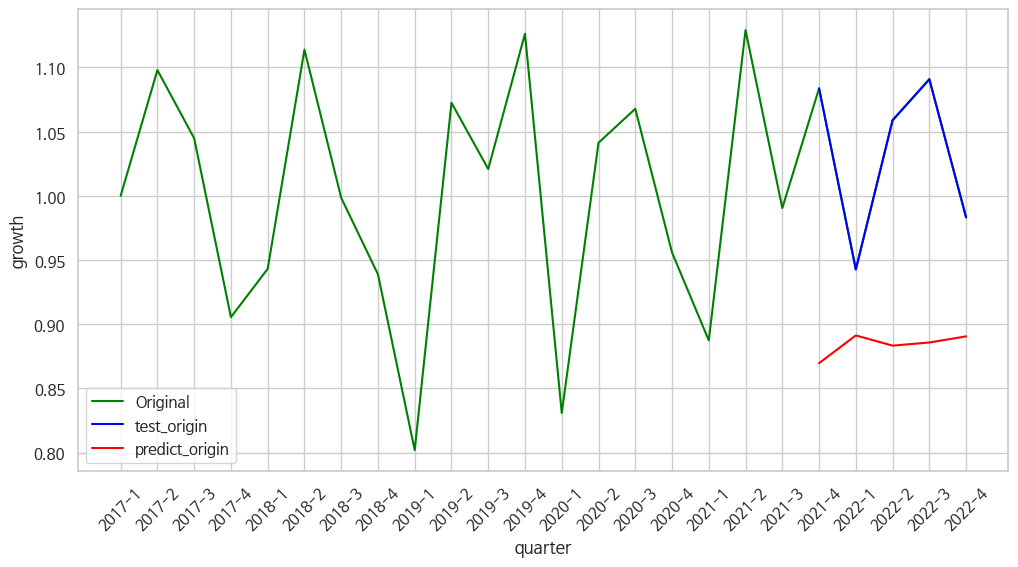

In [289]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [290]:
## error의 요약 통계량
error.describe()

count    5.000000
mean     0.147784
std      0.072072
min      0.051382
25%      0.092750
50%      0.175592
75%      0.205094
max      0.214101
dtype: float64

In [291]:
### 23년 1분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 18ms/step
[[0.33172864]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9104317426681519 


## 23년 1분기 시장성 예측

In [292]:
# 시장성을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_conv[['성장성', '분기당_매출_금액', '순점포증감률']]
y = sin_conv.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성    분기당_매출_금액    순점포증감률
0   1.000000  15090165444  1.234568
1   1.097949  16568229263  3.571429
2   1.044820  17310811266 -1.204819
3   0.905452  15674109984 -1.219512
4   0.943073  14781832109 -3.797468
5   1.113868  16465014523 -2.597403
6   0.998443  16439378593  4.938272
7   0.938836  15433879411 -3.846154
8   0.801880  12376114168  1.265823
9   1.072477  13273101496 -3.947368
10  1.020857  13549942052  0.000000
11  1.126286  15261108593 -2.631579
12  0.830779  12678606342 -1.298701
13  1.041332  13202635113  2.500000
14  1.067797  14097727725  1.234568
15  0.955822  13474922027  1.219512
16  0.887361  11957120245 -5.128205
17  1.129111  13500917234  1.265823
18  0.990444  13371898951 -1.282051
19  1.083713  14491304613 -2.631579
20  0.942607  13659609646 -2.702703
21  1.058867  14463711649 -1.351351
22  1.090826  15777390186  0.000000
23  0.983232  15512842635  2.631579
--------------------------------------------------------------------------------
             시장성
0 

In [293]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [294]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (21, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (21, 1)


In [295]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

[[0.78533855 0.46819874 0.37519123]
 [0.88300244 0.71357684 0.50943396]
 [0.55420354 0.66416279 0.77085402]]


In [296]:
### 학습용 / 평가용 데이터 생성

'''
# TEST_SIZE 설정
   (1) TEST_SIZE = 5로 설정
   (2) TEST_SIZE = 5는 가장 최근 5분기의 데이터로 모델이 매출액을 예측
   (3) 학습은 과거부터 5분기 이전의 데이터를 학습
'''

## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (16, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (16, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (16, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (16, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [297]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_45 (LSTM)              (None, 32)                12416     
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [298]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.0942
Epoch 1: val_loss improved from inf to 0.08430, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.0942 - val_loss: 0.0843
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.0937
Epoch 2: val_loss improved from 0.08430 to 0.08379, saving model to stock_model.h5
1/1 [==============================] - 0s 77ms/step - loss: 0.0937 - val_loss: 0.0838
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.0931
Epoch 3: val_loss improved from 0.08379 to 0.08329, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.0931 - val_loss: 0.0833
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.0926
Epoch 4: val_loss improved from 0.08329 to 0.08279, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.0926 - val_loss: 0.0828
Epoch 5/300
1/1 [=================

In [299]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 582ms/step
[[0.16004834]
 [0.20416477]
 [0.1723534 ]
 [0.17514515]
 [0.17622392]]


In [300]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2021-4,0.708469,0.160048
2022-1,0.829812,0.204165
2022-2,0.782212,0.172353
2022-3,1.000000,0.175145
2022-4,0.979206,0.176224


In [301]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 5].values       # 시장성이 sin_conv의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2021-4,0.708469,0.160048,1.514778e+07,-6121691.0,2.126947e+07
2022-1,0.829812,0.204165,1.985382e+07,-4410717.5,2.426453e+07
2022-2,0.782212,0.172353,1.800774e+07,-5644462.0,2.365220e+07
2022-3,1.000000,0.175145,2.645425e+07,-5536189.5,3.199044e+07
2022-4,0.979206,0.176224,2.564779e+07,-5494351.5,3.114214e+07


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


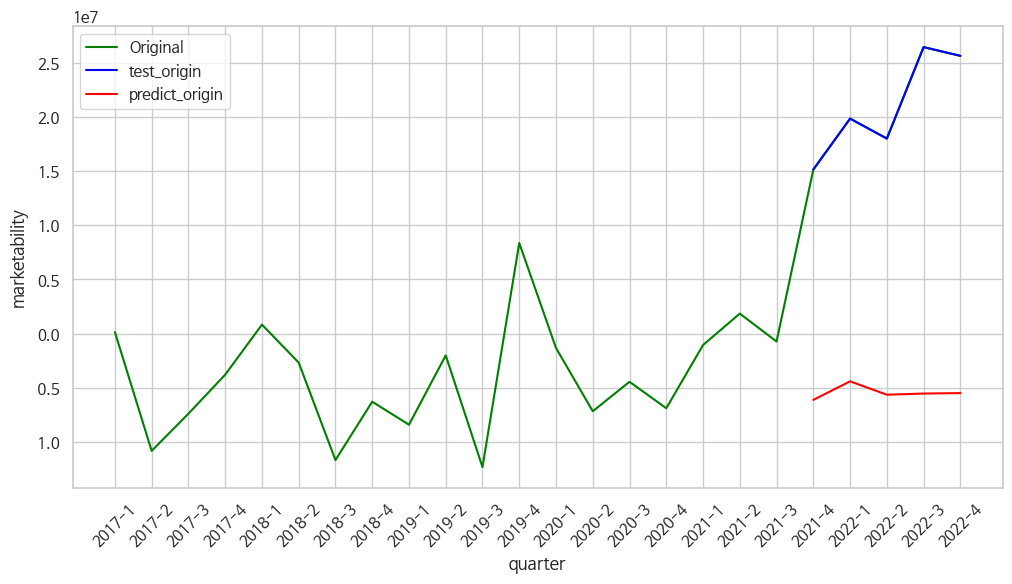

In [302]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [303]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     2.646376e+07
std      4.799834e+06
min      2.126947e+07
25%      2.365220e+07
50%      2.426453e+07
75%      3.114214e+07
max      3.199044e+07
dtype: float64

In [304]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 19ms/step
[[0.20945027]]
--------------------------------------------------------------------------------
예측된 시장성  : -4205729.5 


## 23년 1분기 순점포증감률 예측

In [305]:
# 순점포증감률을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 시장성 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_conv[['성장성', '분기당_매출_금액', '시장성']]
y = sin_conv.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성    분기당_매출_금액           시장성
0   1.000000  15090165444  1.323951e+05
1   1.097949  16568229263 -1.083172e+07
2   1.044820  17310811266 -7.397627e+06
3   0.905452  15674109984 -3.795571e+06
4   0.943073  14781832109  8.262468e+05
5   1.113868  16465014523 -2.677290e+06
6   0.998443  16439378593 -1.167881e+07
7   0.938836  15433879411 -6.290746e+06
8   0.801880  12376114168 -8.412306e+06
9   1.072477  13273101496 -2.017622e+06
10  1.020857  13549942052 -1.232886e+07
11  1.126286  15261108593  8.366798e+06
12  0.830779  12678606342 -1.331752e+06
13  1.041332  13202635113 -7.169836e+06
14  1.067797  14097727725 -4.450322e+06
15  0.955822  13474922027 -6.893093e+06
16  0.887361  11957120245 -1.055772e+06
17  1.129111  13500917234  1.845858e+06
18  0.990444  13371898951 -7.321959e+05
19  1.083713  14491304613  1.514778e+07
20  0.942607  13659609646  1.985382e+07
21  1.058867  14463711649  1.800774e+07
22  1.090826  15777390186  2.645425e+07
23  0.983232  15512842635  2.564779e+07


In [306]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [307]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (21, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (21, 1)


In [308]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

[[0.78533855 0.46819874 0.78221164]
 [0.88300244 0.71357684 1.        ]
 [0.55420354 0.66416279 0.97920597]]


In [309]:
### 학습용 / 평가용 데이터 생성

'''
# TEST_SIZE 설정
   (1) TEST_SIZE = 5로 설정
   (2) TEST_SIZE = 5는 가장 최근 5분기의 데이터로 모델이 매출액을 예측
   (3) 학습은 과거부터 5분기 이전의 데이터를 학습
'''

## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (16, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (16, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (16, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (16, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [310]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_47 (LSTM)              (None, 32)                12416     
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [311]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.2624
Epoch 1: val_loss improved from inf to 0.32566, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.2624 - val_loss: 0.3257
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.2616
Epoch 2: val_loss improved from 0.32566 to 0.32482, saving model to stock_model.h5
1/1 [==============================] - 0s 82ms/step - loss: 0.2616 - val_loss: 0.3248
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.2608
Epoch 3: val_loss improved from 0.32482 to 0.32398, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.2608 - val_loss: 0.3240
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.2600
Epoch 4: val_loss improved from 0.32398 to 0.32314, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.2600 - val_loss: 0.3231
Epoch 5/300
1/1 [=================

In [312]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 566ms/step
[[0.21819839]
 [0.2764284 ]
 [0.27109176]
 [0.3071036 ]
 [0.30777627]]


In [313]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2021-4,0.248014,0.218198
2022-1,0.240948,0.276428
2022-2,0.375191,0.271092
2022-3,0.509434,0.307104
2022-4,0.770854,0.307776


In [314]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_conv의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2021-4,0.248014,0.218198,-2.631579,-2.931716,0.300137
2022-1,0.240948,0.276428,-2.702703,-2.345545,-0.357158
2022-2,0.375191,0.271092,-1.351351,-2.399266,1.047915
2022-3,0.509434,0.307104,0.000000,-2.036754,2.036754
2022-4,0.770854,0.307776,2.631579,-2.029982,4.661561


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


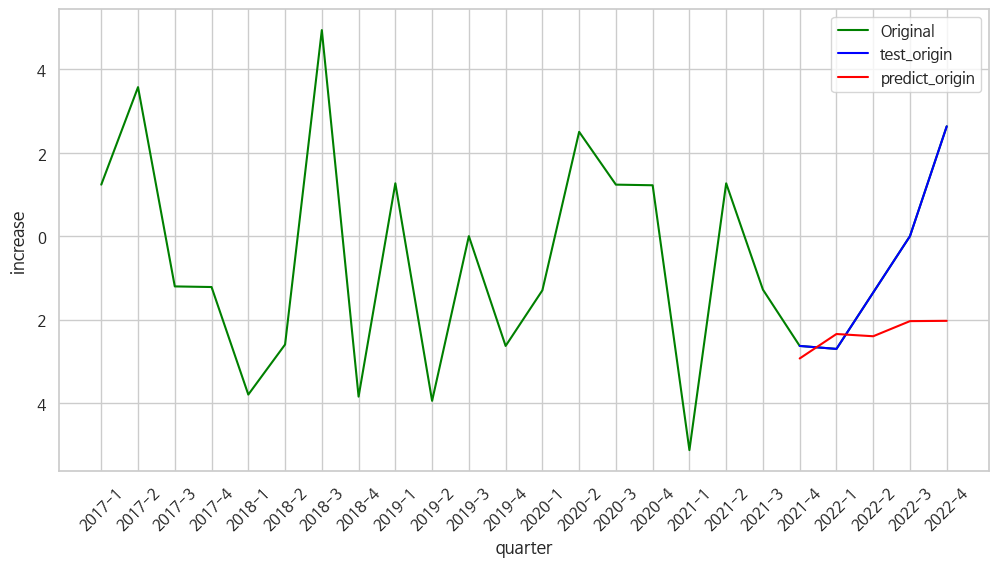

In [315]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [316]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     1.537842
std      1.960198
min     -0.357158
25%      0.300137
50%      1.047915
75%      2.036754
max      4.661561
dtype: float64

In [317]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 20ms/step
[[0.34758636]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -1.629235029220581 


## 원본 데이터에 예측값 추가하기

In [318]:
print(sales)
print(growth)
print(marketability)
print(increase)

13212016000.0
0.91043174
-4205729.5
-1.629235


In [319]:
sin_conv.loc[24] = ['2023-1', '편의점', sales, growth, increase, marketability]

<ipython-input-319-8a0483b71385>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_conv.loc[24] = ['2023-1', '편의점', sales, growth, increase, marketability]


In [320]:
sin_conv

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,편의점,1.509017e+10,1.000000,1.234568,1.323951e+05
1,2017-2,편의점,1.656823e+10,1.097949,3.571429,-1.083172e+07
2,2017-3,편의점,1.731081e+10,1.044820,-1.204819,-7.397627e+06
3,2017-4,편의점,1.567411e+10,0.905452,-1.219512,-3.795571e+06
4,2018-1,편의점,1.478183e+10,0.943073,-3.797468,8.262468e+05
5,2018-2,편의점,1.646501e+10,1.113868,-2.597403,-2.677290e+06
6,2018-3,편의점,1.643938e+10,0.998443,4.938272,-1.167881e+07
7,2018-4,편의점,1.543388e+10,0.938836,-3.846154,-6.290746e+06
8,2019-1,편의점,1.237611e+10,0.801880,1.265823,-8.412306e+06
9,2019-2,편의점,1.327310e+10,1.072477,-3.947368,-2.017622e+06


## 23년 2분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [321]:
################ 매출 ####################

# 총 매출액을 예측하기 위한 지표로는 성장성, 시장성, 순점포증감률 선정.

### X / y 데이터 생성
X = sin_conv[['성장성', '시장성', '순점포증감률']]
y = sin_conv.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  1.323951e+05  1.234568
1   1.097949 -1.083172e+07  3.571429
2   1.044820 -7.397627e+06 -1.204819
3   0.905452 -3.795571e+06 -1.219512
4   0.943073  8.262468e+05 -3.797468
5   1.113868 -2.677290e+06 -2.597403
6   0.998443 -1.167881e+07  4.938272
7   0.938836 -6.290746e+06 -3.846154
8   0.801880 -8.412306e+06  1.265823
9   1.072477 -2.017622e+06 -3.947368
10  1.020857 -1.232886e+07  0.000000
11  1.126286  8.366798e+06 -2.631579
12  0.830779 -1.331752e+06 -1.298701
13  1.041332 -7.169836e+06  2.500000
14  1.067797 -4.450322e+06  1.234568
15  0.955822 -6.893093e+06  1.219512
16  0.887361 -1.055772e+06 -5.128205
17  1.129111  1.845858e+06  1.265823
18  0.990444 -7.321959e+05 -1.282051
19  1.083713  1.514778e+07 -2.631579
20  0.942607  1.985382e+07 -2.702703
21  1.058867  1.800774e+07 -1.351351
22  1.090826  2.645425e+07  0.000000
23  0.983232  2.564779e+07  2.631579
24  0.910432 -4.205730e+06 -1.629235
--------------------------------------

In [322]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [323]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (22, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)
[[0.88300244 1.         0.50943396]
 [0.55420354 0.97920597 0.77085402]
 [0.33172874 0.20945027 0.34758637]]


In [324]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (17, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (17, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (17, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (17, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [325]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_49 (LSTM)              (None, 32)                12416     
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [326]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.3425
Epoch 1: val_loss improved from inf to 0.11443, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.3425 - val_loss: 0.1144
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.3416
Epoch 2: val_loss improved from 0.11443 to 0.11389, saving model to stock_model.h5
1/1 [==============================] - 0s 98ms/step - loss: 0.3416 - val_loss: 0.1139
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.3407
Epoch 3: val_loss improved from 0.11389 to 0.11335, saving model to stock_model.h5
1/1 [==============================] - 0s 68ms/step - loss: 0.3407 - val_loss: 0.1134
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.3399
Epoch 4: val_loss improved from 0.11335 to 0.11282, saving model to stock_model.h5
1/1 [==============================] - 0s 81ms/step - loss: 0.3399 - val_loss: 0.1128
Epoch 5/300
1/1 [=================

In [327]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 660ms/step
[[0.30590436]
 [0.24939995]
 [0.2527721 ]
 [0.24964833]
 [0.2958547 ]]


In [328]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.318003,0.305904
2022-2,0.468199,0.249400
2022-3,0.713577,0.252772
2022-4,0.664163,0.249648
2023-1,0.234398,0.295855


In [329]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_conv의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.318003,0.305904,1.365961e+10,1.359484e+10,6.477163e+07
2022-2,0.468199,0.249400,1.446371e+10,1.329233e+10,1.171382e+09
2022-3,0.713577,0.252772,1.577739e+10,1.331038e+10,2.467006e+09
2022-4,0.664163,0.249648,1.551284e+10,1.329366e+10,2.219182e+09
2023-1,0.234398,0.295855,1.321202e+10,1.354103e+10,-3.290184e+08


In [330]:
df_test = df_test.reset_index()

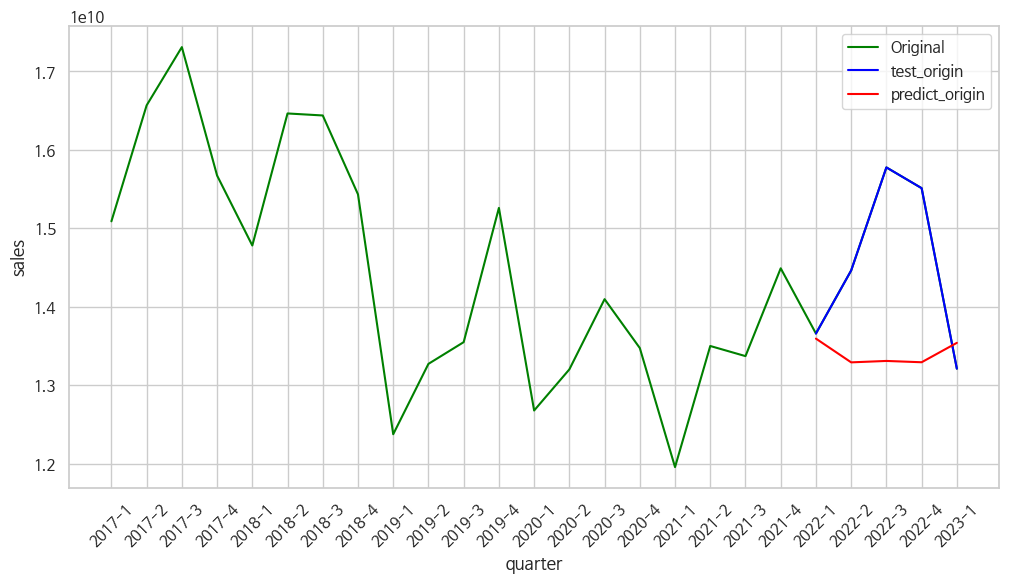

In [331]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [332]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     1.118665e+09
std      1.248841e+09
min     -3.290184e+08
25%      6.477163e+07
50%      1.171382e+09
75%      2.219182e+09
max      2.467006e+09
dtype: float64

In [333]:
### 23년 2분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 26ms/step
[[0.2884915]]
--------------------------------------------------------------------------------
예측된 매출  : 13501615104.0 


### 성장성

In [334]:
### X / y 데이터 생성
X = sin_conv[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_conv.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   1.509017e+10  1.323951e+05  1.234568
1   1.656823e+10 -1.083172e+07  3.571429
2   1.731081e+10 -7.397627e+06 -1.204819
3   1.567411e+10 -3.795571e+06 -1.219512
4   1.478183e+10  8.262468e+05 -3.797468
5   1.646501e+10 -2.677290e+06 -2.597403
6   1.643938e+10 -1.167881e+07  4.938272
7   1.543388e+10 -6.290746e+06 -3.846154
8   1.237611e+10 -8.412306e+06  1.265823
9   1.327310e+10 -2.017622e+06 -3.947368
10  1.354994e+10 -1.232886e+07  0.000000
11  1.526111e+10  8.366798e+06 -2.631579
12  1.267861e+10 -1.331752e+06 -1.298701
13  1.320264e+10 -7.169836e+06  2.500000
14  1.409773e+10 -4.450322e+06  1.234568
15  1.347492e+10 -6.893093e+06  1.219512
16  1.195712e+10 -1.055772e+06 -5.128205
17  1.350092e+10  1.845858e+06  1.265823
18  1.337190e+10 -7.321959e+05 -1.282051
19  1.449130e+10  1.514778e+07 -2.631579
20  1.365961e+10  1.985382e+07 -2.702703
21  1.446371e+10  1.800774e+07 -1.351351
22  1.577739e+10  2.645425e+07  0.000000
23  1.551284e+10

In [335]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [336]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (22, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)
[[0.71357684 1.         0.50943396]
 [0.66416279 0.97920597 0.77085402]
 [0.23439817 0.20945027 0.34758637]]


In [337]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (17, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (17, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (17, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (17, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [338]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_51 (LSTM)              (None, 32)                12416     
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [339]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.4139
Epoch 1: val_loss improved from inf to 0.54702, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4139 - val_loss: 0.5470
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.4129
Epoch 2: val_loss improved from 0.54702 to 0.54603, saving model to stock_model.h5
1/1 [==============================] - 0s 222ms/step - loss: 0.4129 - val_loss: 0.5460
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.4120
Epoch 3: val_loss improved from 0.54603 to 0.54503, saving model to stock_model.h5
1/1 [==============================] - 0s 143ms/step - loss: 0.4120 - val_loss: 0.5450
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.4110
Epoch 4: val_loss improved from 0.54503 to 0.54404, saving model to stock_model.h5
1/1 [==============================] - 0s 69ms/step - loss: 0.4110 - val_loss: 0.5440
Epoch 5/300
1/1 [===============

In [340]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 575ms/step
[[0.2683279 ]
 [0.24421003]
 [0.25128952]
 [0.26546887]
 [0.32548842]]


In [341]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.430055,0.268328
2022-2,0.785339,0.244210
2022-3,0.883002,0.251290
2022-4,0.554204,0.265469
2023-1,0.331729,0.325488


In [342]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 3].values       # 성장성이 sin_conv의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.430055,0.268328,0.942607,0.889685,0.052922
2022-2,0.785339,0.244210,1.058867,0.881793,0.177074
2022-3,0.883002,0.251290,1.090826,0.884109,0.206716
2022-4,0.554204,0.265469,0.983232,0.888749,0.094483
2023-1,0.331729,0.325488,0.910432,0.908390,0.002042


In [343]:
df_test = df_test.reset_index()

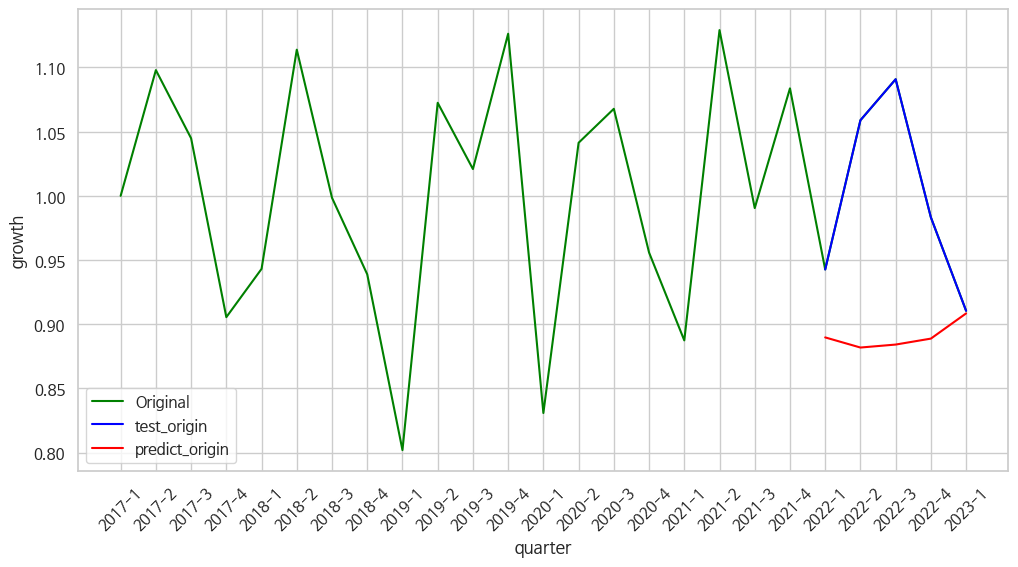

In [344]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [345]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     0.106648
std      0.085074
min      0.002042
25%      0.052922
50%      0.094483
75%      0.177074
max      0.206716
dtype: float64

In [346]:
### 23년 2분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 22ms/step
[[0.34717596]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9154865145683289 


### 시장성

In [347]:
### X / y 데이터 생성
X = sin_conv[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_conv.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   1.509017e+10  1.000000  1.234568
1   1.656823e+10  1.097949  3.571429
2   1.731081e+10  1.044820 -1.204819
3   1.567411e+10  0.905452 -1.219512
4   1.478183e+10  0.943073 -3.797468
5   1.646501e+10  1.113868 -2.597403
6   1.643938e+10  0.998443  4.938272
7   1.543388e+10  0.938836 -3.846154
8   1.237611e+10  0.801880  1.265823
9   1.327310e+10  1.072477 -3.947368
10  1.354994e+10  1.020857  0.000000
11  1.526111e+10  1.126286 -2.631579
12  1.267861e+10  0.830779 -1.298701
13  1.320264e+10  1.041332  2.500000
14  1.409773e+10  1.067797  1.234568
15  1.347492e+10  0.955822  1.219512
16  1.195712e+10  0.887361 -5.128205
17  1.350092e+10  1.129111  1.265823
18  1.337190e+10  0.990444 -1.282051
19  1.449130e+10  1.083713 -2.631579
20  1.365961e+10  0.942607 -2.702703
21  1.446371e+10  1.058867 -1.351351
22  1.577739e+10  1.090826  0.000000
23  1.551284e+10  0.983232  2.631579
24  1.321202e+10  0.910432 -1.629235
--------------------------------------

In [348]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [349]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (22, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)
[[0.71357684 0.88300244 0.50943396]
 [0.66416279 0.55420354 0.77085402]
 [0.23439817 0.33172874 0.34758637]]


In [350]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (17, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (17, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (17, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (17, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [351]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_53 (LSTM)              (None, 32)                12416     
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [352]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.0957
Epoch 1: val_loss improved from inf to 0.15918, saving model to stock_model.h5
1/1 [==============================] - 3s 3s/step - loss: 0.0957 - val_loss: 0.1592
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.0951
Epoch 2: val_loss improved from 0.15918 to 0.15855, saving model to stock_model.h5
1/1 [==============================] - 0s 89ms/step - loss: 0.0951 - val_loss: 0.1586
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.0946
Epoch 3: val_loss improved from 0.15855 to 0.15793, saving model to stock_model.h5
1/1 [==============================] - 0s 75ms/step - loss: 0.0946 - val_loss: 0.1579
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.0940
Epoch 4: val_loss improved from 0.15793 to 0.15730, saving model to stock_model.h5
1/1 [==============================] - 0s 66ms/step - loss: 0.0940 - val_loss: 0.1573
Epoch 5/300
1/1 [=================

In [353]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 749ms/step
[[0.18163878]
 [0.160162  ]
 [0.1645781 ]
 [0.16900375]
 [0.20391259]]


In [354]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.829812,0.181639
2022-2,0.782212,0.160162
2022-3,1.000000,0.164578
2022-4,0.979206,0.169004
2023-1,0.209450,0.203913


In [355]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 5].values       # 시장성이 sin_conv의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.829812,0.181639,1.985382e+07,-5284346.0,2.513816e+07
2022-2,0.782212,0.160162,1.800774e+07,-6117282.5,2.412502e+07
2022-3,1.000000,0.164578,2.645425e+07,-5946012.5,3.240026e+07
2022-4,0.979206,0.169004,2.564779e+07,-5774371.5,3.142216e+07
2023-1,0.209450,0.203913,-4.205730e+06,-4420498.5,2.147690e+05


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


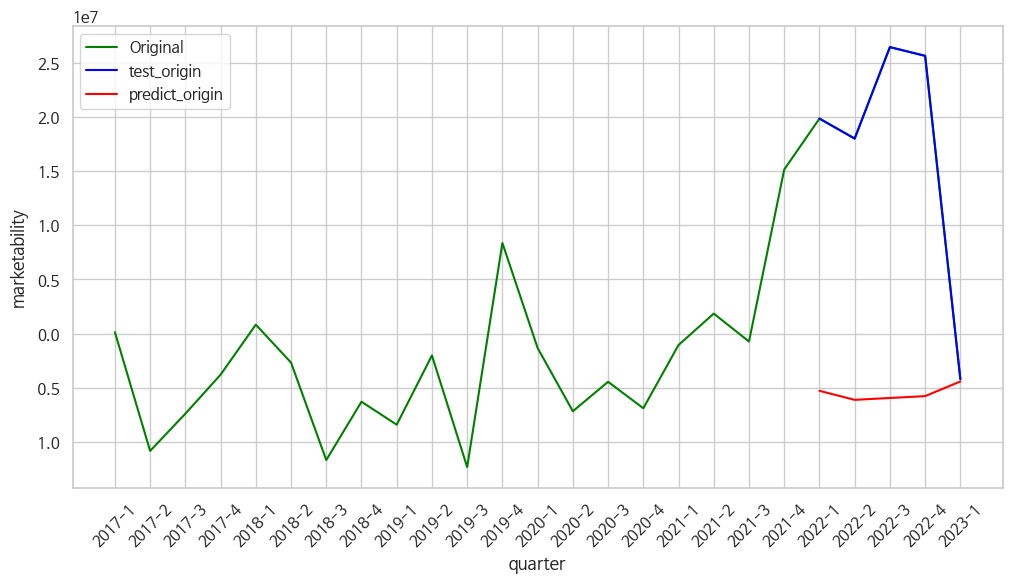

In [356]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [357]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     2.266008e+07
std      1.307406e+07
min      2.147690e+05
25%      2.412502e+07
50%      2.513816e+07
75%      3.142216e+07
max      3.240026e+07
dtype: float64

In [358]:
### 23년 2분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 26ms/step
[[0.20748582]]
--------------------------------------------------------------------------------
예측된 시장성  : -4281917.0 


### 순점포증감률

In [359]:
### X / y 데이터 생성
X = sin_conv[['분기당_매출_금액', '성장성', '시장성']]
y = sin_conv.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   1.509017e+10  1.000000  1.323951e+05
1   1.656823e+10  1.097949 -1.083172e+07
2   1.731081e+10  1.044820 -7.397627e+06
3   1.567411e+10  0.905452 -3.795571e+06
4   1.478183e+10  0.943073  8.262468e+05
5   1.646501e+10  1.113868 -2.677290e+06
6   1.643938e+10  0.998443 -1.167881e+07
7   1.543388e+10  0.938836 -6.290746e+06
8   1.237611e+10  0.801880 -8.412306e+06
9   1.327310e+10  1.072477 -2.017622e+06
10  1.354994e+10  1.020857 -1.232886e+07
11  1.526111e+10  1.126286  8.366798e+06
12  1.267861e+10  0.830779 -1.331752e+06
13  1.320264e+10  1.041332 -7.169836e+06
14  1.409773e+10  1.067797 -4.450322e+06
15  1.347492e+10  0.955822 -6.893093e+06
16  1.195712e+10  0.887361 -1.055772e+06
17  1.350092e+10  1.129111  1.845858e+06
18  1.337190e+10  0.990444 -7.321959e+05
19  1.449130e+10  1.083713  1.514778e+07
20  1.365961e+10  0.942607  1.985382e+07
21  1.446371e+10  1.058867  1.800774e+07
22  1.577739e+10  1.090826  2.645425e+07
23  1.551284e+10

In [360]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [361]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (22, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)
[[0.71357684 0.88300244 1.        ]
 [0.66416279 0.55420354 0.97920597]
 [0.23439817 0.33172874 0.20945027]]


In [362]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (17, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (17, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (17, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (17, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [363]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_55 (LSTM)              (None, 32)                12416     
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [364]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.2523
Epoch 1: val_loss improved from inf to 0.32765, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.2523 - val_loss: 0.3277
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.2515
Epoch 2: val_loss improved from 0.32765 to 0.32683, saving model to stock_model.h5
1/1 [==============================] - 0s 75ms/step - loss: 0.2515 - val_loss: 0.3268
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.2507
Epoch 3: val_loss improved from 0.32683 to 0.32601, saving model to stock_model.h5
1/1 [==============================] - 0s 78ms/step - loss: 0.2507 - val_loss: 0.3260
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.2499
Epoch 4: val_loss improved from 0.32601 to 0.32520, saving model to stock_model.h5
1/1 [==============================] - 0s 81ms/step - loss: 0.2499 - val_loss: 0.3252
Epoch 5/300
1/1 [=================

In [365]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 581ms/step
[[0.24700639]
 [0.25052288]
 [0.28422803]
 [0.28737515]
 [0.3285512 ]]


In [366]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.240948,0.247006
2022-2,0.375191,0.250523
2022-3,0.509434,0.284228
2022-4,0.770854,0.287375
2023-1,0.347586,0.328551


In [367]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_conv의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.240948,0.247006,-2.702703,-2.641721,-0.060982
2022-2,0.375191,0.250523,-1.351351,-2.606322,1.254971
2022-3,0.509434,0.284228,0.000000,-2.267030,2.267030
2022-4,0.770854,0.287375,2.631579,-2.235350,4.866929
2023-1,0.347586,0.328551,-1.629235,-1.820852,0.191617


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


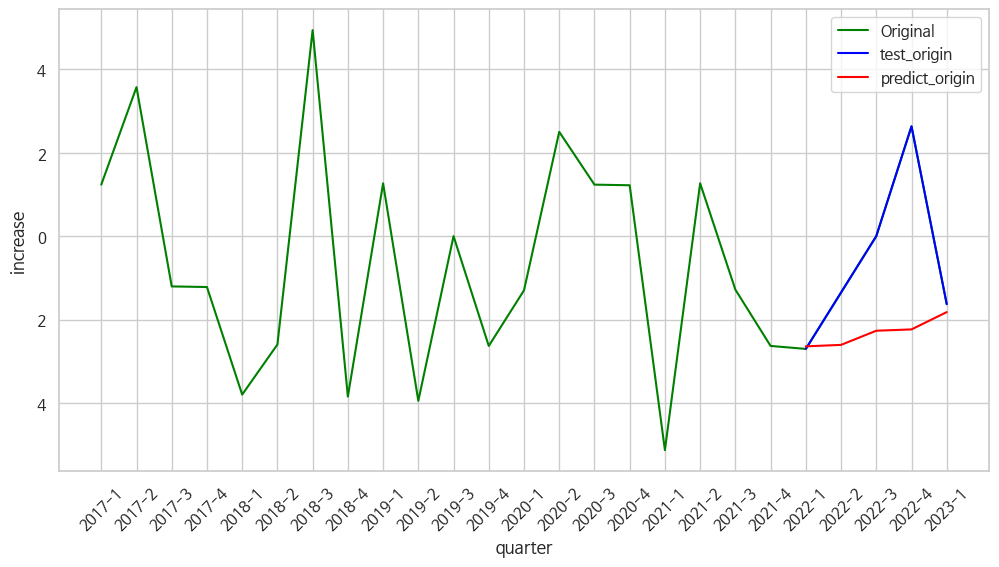

In [368]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [369]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     1.703913
std      1.995320
min     -0.060982
25%      0.191617
50%      1.254971
75%      2.267030
max      4.866929
dtype: float64

In [370]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 16ms/step
[[0.3187804]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -1.919209599494934 


### 추가


In [371]:
sin_conv.loc[25] = ['2023-2', '편의점', sales, growth, increase, marketability]

<ipython-input-371-9a9448c061c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_conv.loc[25] = ['2023-2', '편의점', sales, growth, increase, marketability]


In [372]:
sin_conv

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,편의점,1.509017e+10,1.000000,1.234568,1.323951e+05
1,2017-2,편의점,1.656823e+10,1.097949,3.571429,-1.083172e+07
2,2017-3,편의점,1.731081e+10,1.044820,-1.204819,-7.397627e+06
3,2017-4,편의점,1.567411e+10,0.905452,-1.219512,-3.795571e+06
4,2018-1,편의점,1.478183e+10,0.943073,-3.797468,8.262468e+05
5,2018-2,편의점,1.646501e+10,1.113868,-2.597403,-2.677290e+06
6,2018-3,편의점,1.643938e+10,0.998443,4.938272,-1.167881e+07
7,2018-4,편의점,1.543388e+10,0.938836,-3.846154,-6.290746e+06
8,2019-1,편의점,1.237611e+10,0.801880,1.265823,-8.412306e+06
9,2019-2,편의점,1.327310e+10,1.072477,-3.947368,-2.017622e+06


## 23년 3분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [373]:
################ 매출 ####################

### X / y 데이터 생성
X = sin_conv[['성장성', '시장성', '순점포증감률']]
y = sin_conv.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  1.323951e+05  1.234568
1   1.097949 -1.083172e+07  3.571429
2   1.044820 -7.397627e+06 -1.204819
3   0.905452 -3.795571e+06 -1.219512
4   0.943073  8.262468e+05 -3.797468
5   1.113868 -2.677290e+06 -2.597403
6   0.998443 -1.167881e+07  4.938272
7   0.938836 -6.290746e+06 -3.846154
8   0.801880 -8.412306e+06  1.265823
9   1.072477 -2.017622e+06 -3.947368
10  1.020857 -1.232886e+07  0.000000
11  1.126286  8.366798e+06 -2.631579
12  0.830779 -1.331752e+06 -1.298701
13  1.041332 -7.169836e+06  2.500000
14  1.067797 -4.450322e+06  1.234568
15  0.955822 -6.893093e+06  1.219512
16  0.887361 -1.055772e+06 -5.128205
17  1.129111  1.845858e+06  1.265823
18  0.990444 -7.321959e+05 -1.282051
19  1.083713  1.514778e+07 -2.631579
20  0.942607  1.985382e+07 -2.702703
21  1.058867  1.800774e+07 -1.351351
22  1.090826  2.645425e+07  0.000000
23  0.983232  2.564779e+07  2.631579
24  0.910432 -4.205730e+06 -1.629235
25  0.915487 -4.281917e+06 -1.919210
-

In [374]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [375]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (23, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.55420354 0.97920597 0.77085402]
 [0.33172874 0.20945027 0.34758637]
 [0.34717583 0.20748582 0.3187804 ]]


In [376]:
# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (18, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [377]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_57 (LSTM)              (None, 32)                12416     
                                                                 
 dense_28 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [378]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.3425
Epoch 1: val_loss improved from inf to 0.11657, saving model to stock_model.h5
1/1 [==============================] - 3s 3s/step - loss: 0.3425 - val_loss: 0.1166
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.3416
Epoch 2: val_loss improved from 0.11657 to 0.11601, saving model to stock_model.h5
1/1 [==============================] - 0s 96ms/step - loss: 0.3416 - val_loss: 0.1160
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.3407
Epoch 3: val_loss improved from 0.11601 to 0.11544, saving model to stock_model.h5
1/1 [==============================] - 0s 78ms/step - loss: 0.3407 - val_loss: 0.1154
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.3399
Epoch 4: val_loss improved from 0.11544 to 0.11488, saving model to stock_model.h5
1/1 [==============================] - 0s 85ms/step - loss: 0.3399 - val_loss: 0.1149
Epoch 5/300
1/1 [=================

In [379]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 547ms/step
[[0.25104842]
 [0.25452006]
 [0.25139558]
 [0.2979502 ]
 [0.29053324]]


In [380]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.468199,0.251048
2022-3,0.713577,0.254520
2022-4,0.664163,0.251396
2023-1,0.234398,0.297950
2023-2,0.288492,0.290533


In [381]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_conv의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.468199,0.251048,1.446371e+10,1.330116e+10,1.162556e+09
2022-3,0.713577,0.254520,1.577739e+10,1.331974e+10,2.457649e+09
2022-4,0.664163,0.251396,1.551284e+10,1.330301e+10,2.209828e+09
2023-1,0.234398,0.297950,1.321202e+10,1.355225e+10,-3.402383e+08
2023-2,0.288492,0.290533,1.350162e+10,1.351255e+10,-1.093120e+07


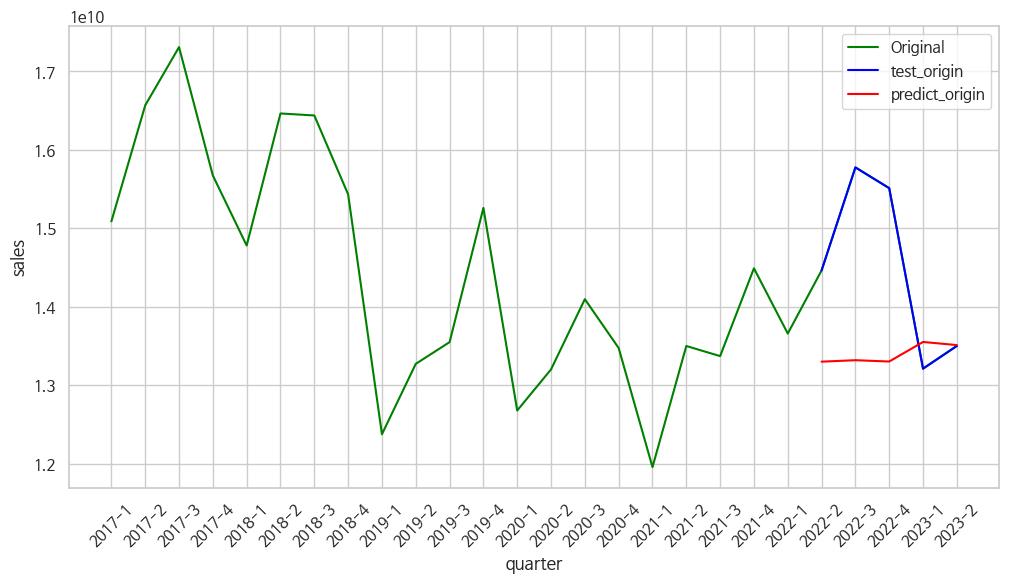

In [382]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [383]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     1.095773e+09
std      1.263646e+09
min     -3.402383e+08
25%     -1.093120e+07
50%      1.162556e+09
75%      2.209828e+09
max      2.457649e+09
dtype: float64

In [384]:
### 23년 3분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 16ms/step
[[0.24821578]]
--------------------------------------------------------------------------------
예측된 매출  : 13285990400.0 


### 성장성

In [385]:
X = sin_conv[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_conv.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   1.509017e+10  1.323951e+05  1.234568
1   1.656823e+10 -1.083172e+07  3.571429
2   1.731081e+10 -7.397627e+06 -1.204819
3   1.567411e+10 -3.795571e+06 -1.219512
4   1.478183e+10  8.262468e+05 -3.797468
5   1.646501e+10 -2.677290e+06 -2.597403
6   1.643938e+10 -1.167881e+07  4.938272
7   1.543388e+10 -6.290746e+06 -3.846154
8   1.237611e+10 -8.412306e+06  1.265823
9   1.327310e+10 -2.017622e+06 -3.947368
10  1.354994e+10 -1.232886e+07  0.000000
11  1.526111e+10  8.366798e+06 -2.631579
12  1.267861e+10 -1.331752e+06 -1.298701
13  1.320264e+10 -7.169836e+06  2.500000
14  1.409773e+10 -4.450322e+06  1.234568
15  1.347492e+10 -6.893093e+06  1.219512
16  1.195712e+10 -1.055772e+06 -5.128205
17  1.350092e+10  1.845858e+06  1.265823
18  1.337190e+10 -7.321959e+05 -1.282051
19  1.449130e+10  1.514778e+07 -2.631579
20  1.365961e+10  1.985382e+07 -2.702703
21  1.446371e+10  1.800774e+07 -1.351351
22  1.577739e+10  2.645425e+07  0.000000
23  1.551284e+10

In [386]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [387]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (23, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.66416279 0.97920597 0.77085402]
 [0.23439817 0.20945027 0.34758637]
 [0.28849159 0.20748582 0.3187804 ]]


In [388]:
# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (18, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [389]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_59 (LSTM)              (None, 32)                12416     
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [390]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.4139
Epoch 1: val_loss improved from inf to 0.50635, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.4139 - val_loss: 0.5063
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.4129
Epoch 2: val_loss improved from 0.50635 to 0.50538, saving model to stock_model.h5
1/1 [==============================] - 0s 75ms/step - loss: 0.4129 - val_loss: 0.5054
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.4120
Epoch 3: val_loss improved from 0.50538 to 0.50442, saving model to stock_model.h5
1/1 [==============================] - 0s 66ms/step - loss: 0.4120 - val_loss: 0.5044
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.4110
Epoch 4: val_loss improved from 0.50442 to 0.50346, saving model to stock_model.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.4110 - val_loss: 0.5035
Epoch 5/300
1/1 [=================

In [391]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 587ms/step
[[0.24421003]
 [0.25128952]
 [0.26546887]
 [0.32548842]
 [0.34717593]]


In [392]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.785339,0.244210
2022-3,0.883002,0.251290
2022-4,0.554204,0.265469
2023-1,0.331729,0.325488
2023-2,0.347176,0.347176


In [393]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 3].values       # 성장성이 sin_conv의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.785339,0.244210,1.058867,0.881793,0.177074
2022-3,0.883002,0.251290,1.090826,0.884109,0.206716
2022-4,0.554204,0.265469,0.983232,0.888749,0.094483
2023-1,0.331729,0.325488,0.910432,0.908390,0.002042
2023-2,0.347176,0.347176,0.915487,0.915487,0.000000


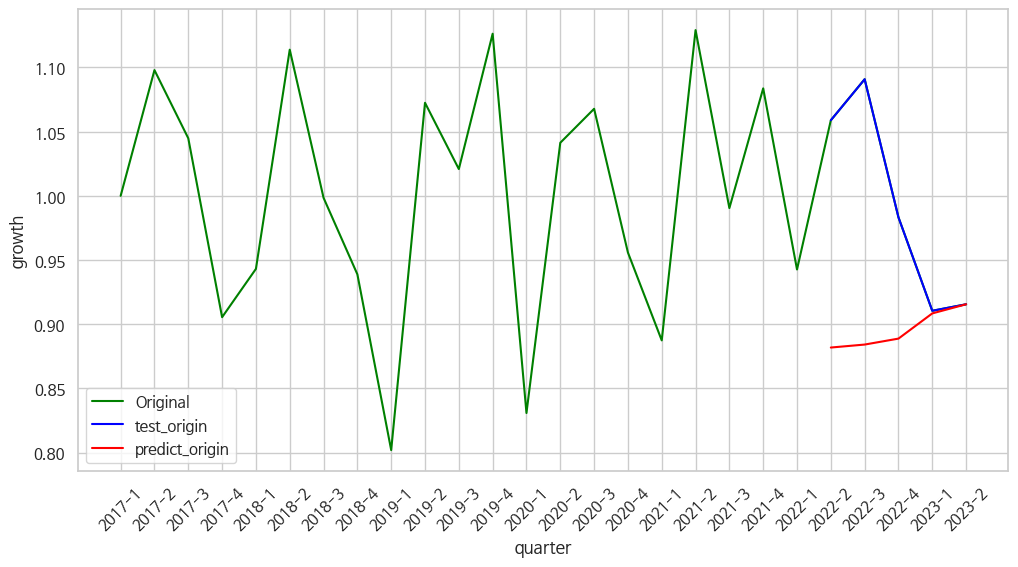

In [394]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [395]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     0.096063
std      0.096018
min      0.000000
25%      0.002042
50%      0.094483
75%      0.177074
max      0.206716
dtype: float64

In [396]:
### 23년 3분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 22ms/step
[[0.30997127]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9033120274543762 


### 시장성

In [397]:
### X / y 데이터 생성
X = sin_conv[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_conv.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   1.509017e+10  1.000000  1.234568
1   1.656823e+10  1.097949  3.571429
2   1.731081e+10  1.044820 -1.204819
3   1.567411e+10  0.905452 -1.219512
4   1.478183e+10  0.943073 -3.797468
5   1.646501e+10  1.113868 -2.597403
6   1.643938e+10  0.998443  4.938272
7   1.543388e+10  0.938836 -3.846154
8   1.237611e+10  0.801880  1.265823
9   1.327310e+10  1.072477 -3.947368
10  1.354994e+10  1.020857  0.000000
11  1.526111e+10  1.126286 -2.631579
12  1.267861e+10  0.830779 -1.298701
13  1.320264e+10  1.041332  2.500000
14  1.409773e+10  1.067797  1.234568
15  1.347492e+10  0.955822  1.219512
16  1.195712e+10  0.887361 -5.128205
17  1.350092e+10  1.129111  1.265823
18  1.337190e+10  0.990444 -1.282051
19  1.449130e+10  1.083713 -2.631579
20  1.365961e+10  0.942607 -2.702703
21  1.446371e+10  1.058867 -1.351351
22  1.577739e+10  1.090826  0.000000
23  1.551284e+10  0.983232  2.631579
24  1.321202e+10  0.910432 -1.629235
25  1.350162e+10  0.915487 -1.919210
-

In [398]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [399]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (23, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.66416279 0.55420354 0.77085402]
 [0.23439817 0.33172874 0.34758637]
 [0.28849159 0.34717583 0.3187804 ]]


In [400]:
# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (18, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [401]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_61 (LSTM)              (None, 32)                12416     
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [402]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.0957
Epoch 1: val_loss improved from inf to 0.23939, saving model to stock_model.h5
1/1 [==============================] - 3s 3s/step - loss: 0.0957 - val_loss: 0.2394
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.0951
Epoch 2: val_loss improved from 0.23939 to 0.23860, saving model to stock_model.h5
1/1 [==============================] - 0s 67ms/step - loss: 0.0951 - val_loss: 0.2386
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.0946
Epoch 3: val_loss improved from 0.23860 to 0.23782, saving model to stock_model.h5
1/1 [==============================] - 0s 66ms/step - loss: 0.0946 - val_loss: 0.2378
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.0940
Epoch 4: val_loss improved from 0.23782 to 0.23705, saving model to stock_model.h5
1/1 [==============================] - 0s 69ms/step - loss: 0.0940 - val_loss: 0.2370
Epoch 5/300
1/1 [=================

In [403]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 794ms/step
[[0.160162  ]
 [0.1645781 ]
 [0.16900375]
 [0.20391259]
 [0.20748584]]


In [404]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.782212,0.160162
2022-3,1.000000,0.164578
2022-4,0.979206,0.169004
2023-1,0.209450,0.203913
2023-2,0.207486,0.207486


In [405]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 5].values       # 시장성이 sin_conv의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.782212,0.160162,1.800774e+07,-6117282.5,2.412502e+07
2022-3,1.000000,0.164578,2.645425e+07,-5946012.5,3.240026e+07
2022-4,0.979206,0.169004,2.564779e+07,-5774371.5,3.142216e+07
2023-1,0.209450,0.203913,-4.205730e+06,-4420498.5,2.147690e+05
2023-2,0.207486,0.207486,-4.281917e+06,-4281916.5,-5.000000e-01


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


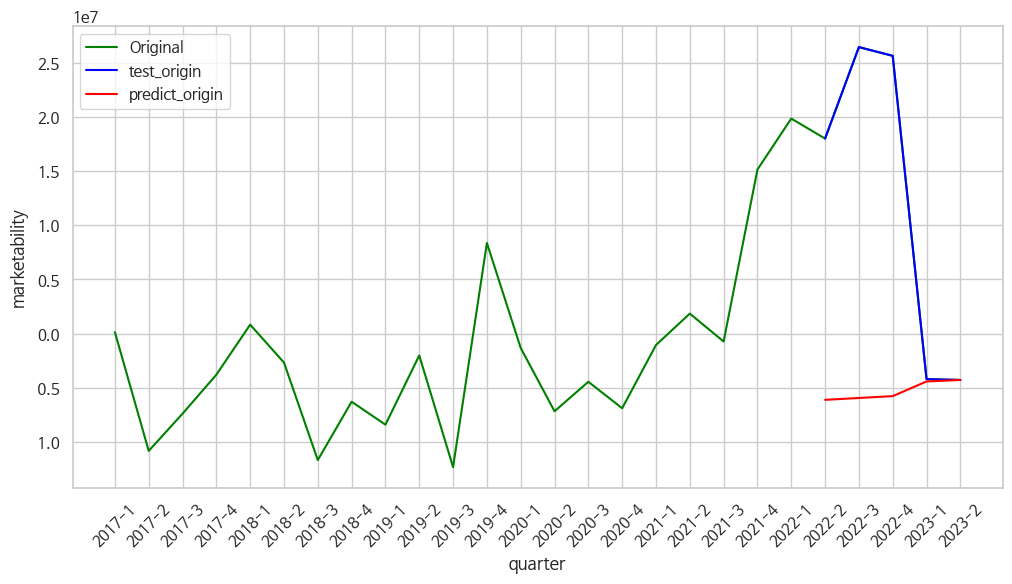

In [406]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [407]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     1.763244e+07
std      1.631469e+07
min     -5.000000e-01
25%      2.147690e+05
50%      2.412502e+07
75%      3.142216e+07
max      3.240026e+07
dtype: float64

In [408]:
### 23년 3분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 24ms/step
[[0.18044144]]
--------------------------------------------------------------------------------
예측된 시장성  : -5330782.5 


### 순점포증감률

In [409]:
### X / y 데이터 생성
X = sin_conv[['분기당_매출_금액', '성장성', '시장성']]
y = sin_conv.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   1.509017e+10  1.000000  1.323951e+05
1   1.656823e+10  1.097949 -1.083172e+07
2   1.731081e+10  1.044820 -7.397627e+06
3   1.567411e+10  0.905452 -3.795571e+06
4   1.478183e+10  0.943073  8.262468e+05
5   1.646501e+10  1.113868 -2.677290e+06
6   1.643938e+10  0.998443 -1.167881e+07
7   1.543388e+10  0.938836 -6.290746e+06
8   1.237611e+10  0.801880 -8.412306e+06
9   1.327310e+10  1.072477 -2.017622e+06
10  1.354994e+10  1.020857 -1.232886e+07
11  1.526111e+10  1.126286  8.366798e+06
12  1.267861e+10  0.830779 -1.331752e+06
13  1.320264e+10  1.041332 -7.169836e+06
14  1.409773e+10  1.067797 -4.450322e+06
15  1.347492e+10  0.955822 -6.893093e+06
16  1.195712e+10  0.887361 -1.055772e+06
17  1.350092e+10  1.129111  1.845858e+06
18  1.337190e+10  0.990444 -7.321959e+05
19  1.449130e+10  1.083713  1.514778e+07
20  1.365961e+10  0.942607  1.985382e+07
21  1.446371e+10  1.058867  1.800774e+07
22  1.577739e+10  1.090826  2.645425e+07
23  1.551284e+10

In [410]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [411]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (23, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.66416279 0.55420354 0.97920597]
 [0.23439817 0.33172874 0.20945027]
 [0.28849159 0.34717583 0.20748582]]


In [412]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (18, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [413]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_63 (LSTM)              (None, 32)                12416     
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [414]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.2523
Epoch 1: val_loss improved from inf to 0.29825, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.2523 - val_loss: 0.2983
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.2515
Epoch 2: val_loss improved from 0.29825 to 0.29746, saving model to stock_model.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.2515 - val_loss: 0.2975
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.2507
Epoch 3: val_loss improved from 0.29746 to 0.29667, saving model to stock_model.h5
1/1 [==============================] - 0s 75ms/step - loss: 0.2507 - val_loss: 0.2967
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.2499
Epoch 4: val_loss improved from 0.29667 to 0.29589, saving model to stock_model.h5
1/1 [==============================] - 0s 74ms/step - loss: 0.2499 - val_loss: 0.2959
Epoch 5/300
1/1 [=================

In [415]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 594ms/step
[[0.25052288]
 [0.28422803]
 [0.28737515]
 [0.3285512 ]
 [0.3187804 ]]


In [416]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.375191,0.250523
2022-3,0.509434,0.284228
2022-4,0.770854,0.287375
2023-1,0.347586,0.328551
2023-2,0.318780,0.318780


In [417]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_conv의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.375191,0.250523,-1.351351,-2.606322,1.254971
2022-3,0.509434,0.284228,0.000000,-2.267030,2.267030
2022-4,0.770854,0.287375,2.631579,-2.235350,4.866929
2023-1,0.347586,0.328551,-1.629235,-1.820852,0.191617
2023-2,0.318780,0.318780,-1.919210,-1.919210,0.000000


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


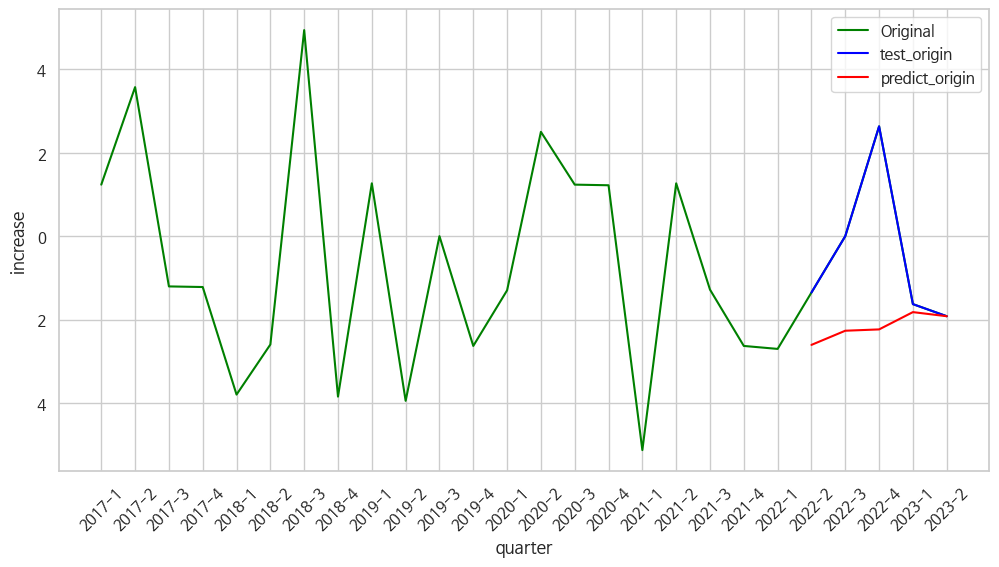

In [418]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [419]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     1.716109
std      1.981977
min      0.000000
25%      0.191617
50%      1.254971
75%      2.267030
max      4.866929
dtype: float64

In [420]:
### 23년 3분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 19ms/step
[[0.2511069]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.6004433631896973 


### 추가

In [421]:
sin_conv.loc[26] = ['2023-3', '편의점', sales, growth, increase, marketability]

<ipython-input-421-036e82104a85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_conv.loc[26] = ['2023-3', '편의점', sales, growth, increase, marketability]


In [422]:
sin_conv

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,편의점,1.509017e+10,1.000000,1.234568,1.323951e+05
1,2017-2,편의점,1.656823e+10,1.097949,3.571429,-1.083172e+07
2,2017-3,편의점,1.731081e+10,1.044820,-1.204819,-7.397627e+06
3,2017-4,편의점,1.567411e+10,0.905452,-1.219512,-3.795571e+06
4,2018-1,편의점,1.478183e+10,0.943073,-3.797468,8.262468e+05
5,2018-2,편의점,1.646501e+10,1.113868,-2.597403,-2.677290e+06
6,2018-3,편의점,1.643938e+10,0.998443,4.938272,-1.167881e+07
7,2018-4,편의점,1.543388e+10,0.938836,-3.846154,-6.290746e+06
8,2019-1,편의점,1.237611e+10,0.801880,1.265823,-8.412306e+06
9,2019-2,편의점,1.327310e+10,1.072477,-3.947368,-2.017622e+06


## 23년 4분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본데이터에 추가

### 매출

In [423]:
### X / y 데이터 생성
X = sin_conv[['성장성', '시장성', '순점포증감률']]
y = sin_conv.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  1.323951e+05  1.234568
1   1.097949 -1.083172e+07  3.571429
2   1.044820 -7.397627e+06 -1.204819
3   0.905452 -3.795571e+06 -1.219512
4   0.943073  8.262468e+05 -3.797468
5   1.113868 -2.677290e+06 -2.597403
6   0.998443 -1.167881e+07  4.938272
7   0.938836 -6.290746e+06 -3.846154
8   0.801880 -8.412306e+06  1.265823
9   1.072477 -2.017622e+06 -3.947368
10  1.020857 -1.232886e+07  0.000000
11  1.126286  8.366798e+06 -2.631579
12  0.830779 -1.331752e+06 -1.298701
13  1.041332 -7.169836e+06  2.500000
14  1.067797 -4.450322e+06  1.234568
15  0.955822 -6.893093e+06  1.219512
16  0.887361 -1.055772e+06 -5.128205
17  1.129111  1.845858e+06  1.265823
18  0.990444 -7.321959e+05 -1.282051
19  1.083713  1.514778e+07 -2.631579
20  0.942607  1.985382e+07 -2.702703
21  1.058867  1.800774e+07 -1.351351
22  1.090826  2.645425e+07  0.000000
23  0.983232  2.564779e+07  2.631579
24  0.910432 -4.205730e+06 -1.629235
25  0.915487 -4.281917e+06 -1.919210
2

In [424]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [425]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (24, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.33172874 0.20945027 0.34758637]
 [0.34717583 0.20748582 0.3187804 ]
 [0.30997131 0.18044144 0.2511069 ]]


In [426]:
# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (19, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [427]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_65 (LSTM)              (None, 32)                12416     
                                                                 
 dense_32 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [428]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.3177
Epoch 1: val_loss improved from inf to 0.14143, saving model to stock_model.h5
1/1 [==============================] - 3s 3s/step - loss: 0.3177 - val_loss: 0.1414
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.3169
Epoch 2: val_loss improved from 0.14143 to 0.14080, saving model to stock_model.h5
1/1 [==============================] - 0s 68ms/step - loss: 0.3169 - val_loss: 0.1408
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.3160
Epoch 3: val_loss improved from 0.14080 to 0.14018, saving model to stock_model.h5
1/1 [==============================] - 0s 83ms/step - loss: 0.3160 - val_loss: 0.1402
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.3152
Epoch 4: val_loss improved from 0.14018 to 0.13956, saving model to stock_model.h5
1/1 [==============================] - 0s 75ms/step - loss: 0.3152 - val_loss: 0.1396
Epoch 5/300
1/1 [=================

In [429]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 700ms/step
[[0.28958407]
 [0.28596705]
 [0.33939692]
 [0.33041164]
 [0.2796546 ]]


In [430]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.713577,0.289584
2022-4,0.664163,0.285967
2023-1,0.234398,0.339397
2023-2,0.288492,0.330412
2023-3,0.248216,0.279655


In [431]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_conv의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.713577,0.289584,1.577739e+10,1.350746e+10,2.269927e+09
2022-4,0.664163,0.285967,1.551284e+10,1.348810e+10,2.024742e+09
2023-1,0.234398,0.339397,1.321202e+10,1.377415e+10,-5.621309e+08
2023-2,0.288492,0.330412,1.350162e+10,1.372604e+10,-2.244270e+08
2023-3,0.248216,0.279655,1.328599e+10,1.345430e+10,-1.683139e+08


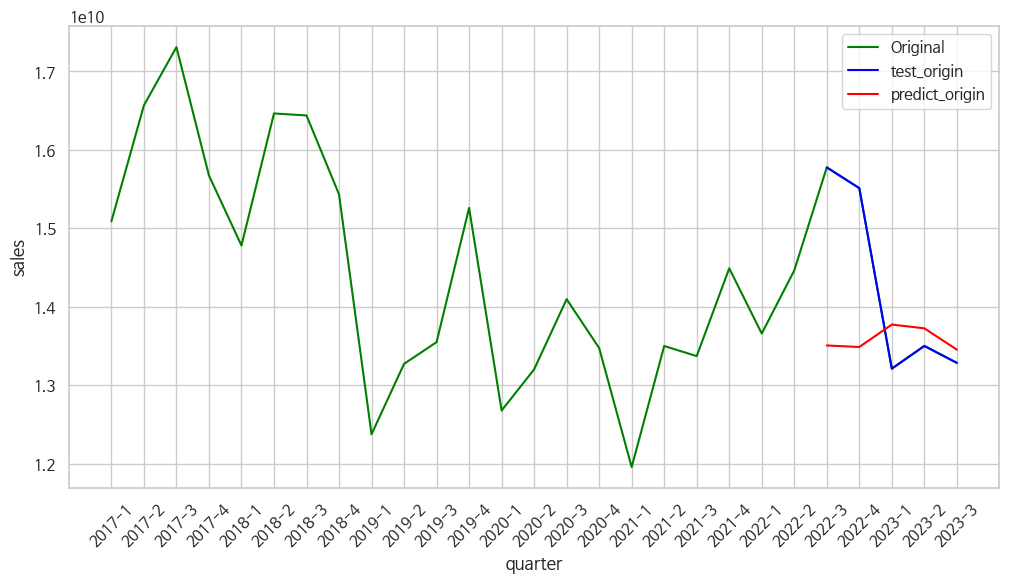

In [432]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [433]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     6.679595e+08
std      1.361616e+09
min     -5.621309e+08
25%     -2.244270e+08
50%     -1.683139e+08
75%      2.024742e+09
max      2.269927e+09
dtype: float64

In [434]:
### 23년 4분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 24ms/step
[[0.22523233]]
--------------------------------------------------------------------------------
예측된 매출  : 13162944512.0 


### 성장성

In [435]:
X = sin_conv[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_conv.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   1.509017e+10  1.323951e+05  1.234568
1   1.656823e+10 -1.083172e+07  3.571429
2   1.731081e+10 -7.397627e+06 -1.204819
3   1.567411e+10 -3.795571e+06 -1.219512
4   1.478183e+10  8.262468e+05 -3.797468
5   1.646501e+10 -2.677290e+06 -2.597403
6   1.643938e+10 -1.167881e+07  4.938272
7   1.543388e+10 -6.290746e+06 -3.846154
8   1.237611e+10 -8.412306e+06  1.265823
9   1.327310e+10 -2.017622e+06 -3.947368
10  1.354994e+10 -1.232886e+07  0.000000
11  1.526111e+10  8.366798e+06 -2.631579
12  1.267861e+10 -1.331752e+06 -1.298701
13  1.320264e+10 -7.169836e+06  2.500000
14  1.409773e+10 -4.450322e+06  1.234568
15  1.347492e+10 -6.893093e+06  1.219512
16  1.195712e+10 -1.055772e+06 -5.128205
17  1.350092e+10  1.845858e+06  1.265823
18  1.337190e+10 -7.321959e+05 -1.282051
19  1.449130e+10  1.514778e+07 -2.631579
20  1.365961e+10  1.985382e+07 -2.702703
21  1.446371e+10  1.800774e+07 -1.351351
22  1.577739e+10  2.645425e+07  0.000000
23  1.551284e+10

In [436]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [437]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (24, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.23439817 0.20945027 0.34758637]
 [0.28849159 0.20748582 0.3187804 ]
 [0.2482157  0.18044144 0.2511069 ]]


In [438]:
# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (19, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [439]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_67 (LSTM)              (None, 32)                12416     
                                                                 
 dense_33 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [440]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.4289
Epoch 1: val_loss improved from inf to 0.52079, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.4289 - val_loss: 0.5208
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.4279
Epoch 2: val_loss improved from 0.52079 to 0.51979, saving model to stock_model.h5
1/1 [==============================] - 0s 69ms/step - loss: 0.4279 - val_loss: 0.5198
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.4270
Epoch 3: val_loss improved from 0.51979 to 0.51880, saving model to stock_model.h5
1/1 [==============================] - 0s 73ms/step - loss: 0.4270 - val_loss: 0.5188
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.4260
Epoch 4: val_loss improved from 0.51880 to 0.51780, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.4260 - val_loss: 0.5178
Epoch 5/300
1/1 [=================

In [441]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 593ms/step
[[0.26041314]
 [0.2759078 ]
 [0.3380947 ]
 [0.3602885 ]
 [0.3210541 ]]


In [442]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.883002,0.260413
2022-4,0.554204,0.275908
2023-1,0.331729,0.338095
2023-2,0.347176,0.360289
2023-3,0.309971,0.321054


In [443]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 3].values       # 성장성이 sin_conv의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.883002,0.260413,1.090826,0.887095,0.203731
2022-4,0.554204,0.275908,0.983232,0.892165,0.091067
2023-1,0.331729,0.338095,0.910432,0.912515,-0.002083
2023-2,0.347176,0.360289,0.915487,0.919777,-0.004291
2023-3,0.309971,0.321054,0.903312,0.906939,-0.003627


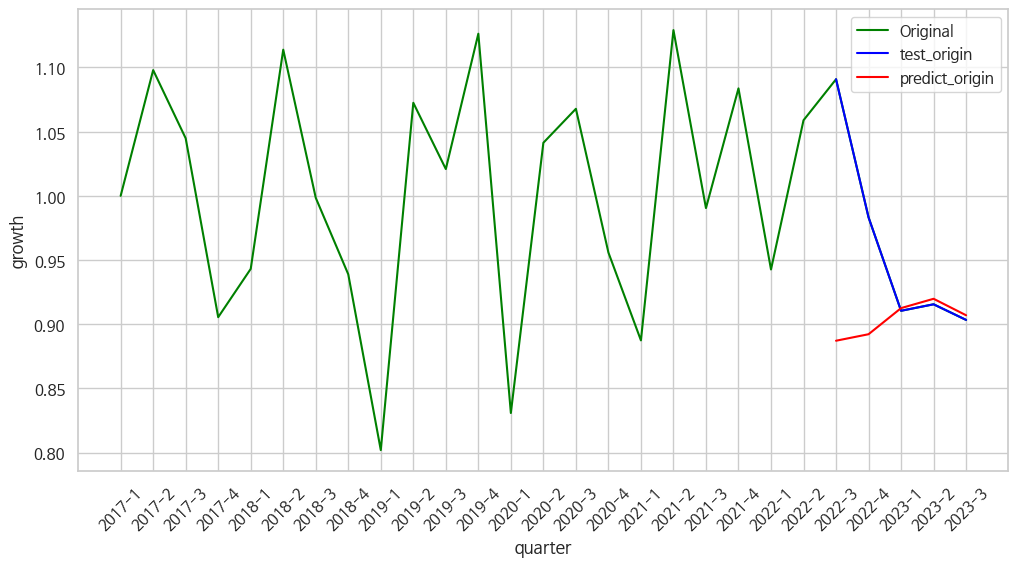

In [444]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [445]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     0.056959
std      0.091670
min     -0.004291
25%     -0.003627
50%     -0.002083
75%      0.091067
max      0.203731
dtype: float64

In [446]:
### 23년 4분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 18ms/step
[[0.23899707]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8800870180130005 


###시장성

In [447]:
### X / y 데이터 생성
X = sin_conv[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_conv.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   1.509017e+10  1.000000  1.234568
1   1.656823e+10  1.097949  3.571429
2   1.731081e+10  1.044820 -1.204819
3   1.567411e+10  0.905452 -1.219512
4   1.478183e+10  0.943073 -3.797468
5   1.646501e+10  1.113868 -2.597403
6   1.643938e+10  0.998443  4.938272
7   1.543388e+10  0.938836 -3.846154
8   1.237611e+10  0.801880  1.265823
9   1.327310e+10  1.072477 -3.947368
10  1.354994e+10  1.020857  0.000000
11  1.526111e+10  1.126286 -2.631579
12  1.267861e+10  0.830779 -1.298701
13  1.320264e+10  1.041332  2.500000
14  1.409773e+10  1.067797  1.234568
15  1.347492e+10  0.955822  1.219512
16  1.195712e+10  0.887361 -5.128205
17  1.350092e+10  1.129111  1.265823
18  1.337190e+10  0.990444 -1.282051
19  1.449130e+10  1.083713 -2.631579
20  1.365961e+10  0.942607 -2.702703
21  1.446371e+10  1.058867 -1.351351
22  1.577739e+10  1.090826  0.000000
23  1.551284e+10  0.983232  2.631579
24  1.321202e+10  0.910432 -1.629235
25  1.350162e+10  0.915487 -1.919210
2

In [448]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [449]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (24, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.23439817 0.33172874 0.34758637]
 [0.28849159 0.34717583 0.3187804 ]
 [0.2482157  0.30997131 0.2511069 ]]


In [450]:
# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (19, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [451]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_69 (LSTM)              (None, 32)                12416     
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [452]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.0901
Epoch 1: val_loss improved from inf to 0.32198, saving model to stock_model.h5
1/1 [==============================] - 3s 3s/step - loss: 0.0901 - val_loss: 0.3220
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.0896
Epoch 2: val_loss improved from 0.32198 to 0.32105, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.0896 - val_loss: 0.3210
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.0891
Epoch 3: val_loss improved from 0.32105 to 0.32012, saving model to stock_model.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.0891 - val_loss: 0.3201
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.0886
Epoch 4: val_loss improved from 0.32012 to 0.31920, saving model to stock_model.h5
1/1 [==============================] - 0s 67ms/step - loss: 0.0886 - val_loss: 0.3192
Epoch 5/300
1/1 [=================

In [453]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 566ms/step
[[0.16182667]
 [0.1661368 ]
 [0.20042285]
 [0.20389086]
 [0.1772134 ]]


In [454]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,1.000000,0.161827
2022-4,0.979206,0.166137
2023-1,0.209450,0.200423
2023-2,0.207486,0.203891
2023-3,0.180441,0.177213


In [455]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 5].values       # 시장성이 sin_conv의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,1.000000,0.161827,2.645425e+07,-6052721.5,3.250697e+07
2022-4,0.979206,0.166137,2.564779e+07,-5885561.0,3.153335e+07
2023-1,0.209450,0.200423,-4.205730e+06,-4555841.0,3.501115e+05
2023-2,0.207486,0.203891,-4.281917e+06,-4421341.0,1.394240e+05
2023-3,0.180441,0.177213,-5.330782e+06,-5455976.0,1.251935e+05


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


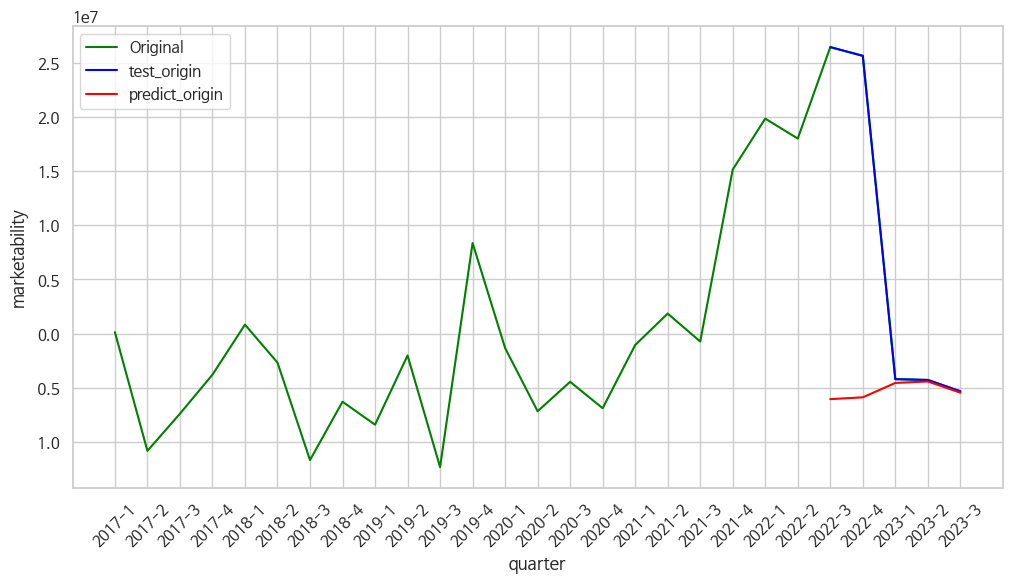

In [456]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [457]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     1.293101e+07
std      1.742956e+07
min      1.251935e+05
25%      1.394240e+05
50%      3.501115e+05
75%      3.153335e+07
max      3.250697e+07
dtype: float64

In [458]:
### 23년 4분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 17ms/step
[[0.13869381]]
--------------------------------------------------------------------------------
예측된 시장성  : -6949886.0 


### 순점포증감률

In [459]:
### X / y 데이터 생성
X = sin_conv[['분기당_매출_금액', '성장성', '시장성']]
y = sin_conv.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   1.509017e+10  1.000000  1.323951e+05
1   1.656823e+10  1.097949 -1.083172e+07
2   1.731081e+10  1.044820 -7.397627e+06
3   1.567411e+10  0.905452 -3.795571e+06
4   1.478183e+10  0.943073  8.262468e+05
5   1.646501e+10  1.113868 -2.677290e+06
6   1.643938e+10  0.998443 -1.167881e+07
7   1.543388e+10  0.938836 -6.290746e+06
8   1.237611e+10  0.801880 -8.412306e+06
9   1.327310e+10  1.072477 -2.017622e+06
10  1.354994e+10  1.020857 -1.232886e+07
11  1.526111e+10  1.126286  8.366798e+06
12  1.267861e+10  0.830779 -1.331752e+06
13  1.320264e+10  1.041332 -7.169836e+06
14  1.409773e+10  1.067797 -4.450322e+06
15  1.347492e+10  0.955822 -6.893093e+06
16  1.195712e+10  0.887361 -1.055772e+06
17  1.350092e+10  1.129111  1.845858e+06
18  1.337190e+10  0.990444 -7.321959e+05
19  1.449130e+10  1.083713  1.514778e+07
20  1.365961e+10  0.942607  1.985382e+07
21  1.446371e+10  1.058867  1.800774e+07
22  1.577739e+10  1.090826  2.645425e+07
23  1.551284e+10

In [460]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [461]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (24, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.23439817 0.33172874 0.20945027]
 [0.28849159 0.34717583 0.20748582]
 [0.2482157  0.30997131 0.18044144]]


In [462]:
# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (19, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [463]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_71 (LSTM)              (None, 32)                12416     
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [464]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.2887
Epoch 1: val_loss improved from inf to 0.23986, saving model to stock_model.h5
1/1 [==============================] - 3s 3s/step - loss: 0.2887 - val_loss: 0.2399
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.2879
Epoch 2: val_loss improved from 0.23986 to 0.23913, saving model to stock_model.h5
1/1 [==============================] - 0s 67ms/step - loss: 0.2879 - val_loss: 0.2391
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.2870
Epoch 3: val_loss improved from 0.23913 to 0.23840, saving model to stock_model.h5
1/1 [==============================] - 0s 70ms/step - loss: 0.2870 - val_loss: 0.2384
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.2861
Epoch 4: val_loss improved from 0.23840 to 0.23767, saving model to stock_model.h5
1/1 [==============================] - 0s 70ms/step - loss: 0.2861 - val_loss: 0.2377
Epoch 5/300
1/1 [=================

In [465]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 807ms/step
[[0.31287545]
 [0.31514567]
 [0.35953134]
 [0.34544444]
 [0.26839614]]


In [466]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.509434,0.312875
2022-4,0.770854,0.315146
2023-1,0.347586,0.359531
2023-2,0.318780,0.345444
2023-3,0.251107,0.268396


In [467]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_conv의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.509434,0.312875,0.000000,-1.978652,1.978652
2022-4,0.770854,0.315146,2.631579,-1.955799,4.587377
2023-1,0.347586,0.359531,-1.629235,-1.508991,-0.120244
2023-2,0.318780,0.345444,-1.919210,-1.650797,-0.268413
2023-3,0.251107,0.268396,-2.600443,-2.426402,-0.174042


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


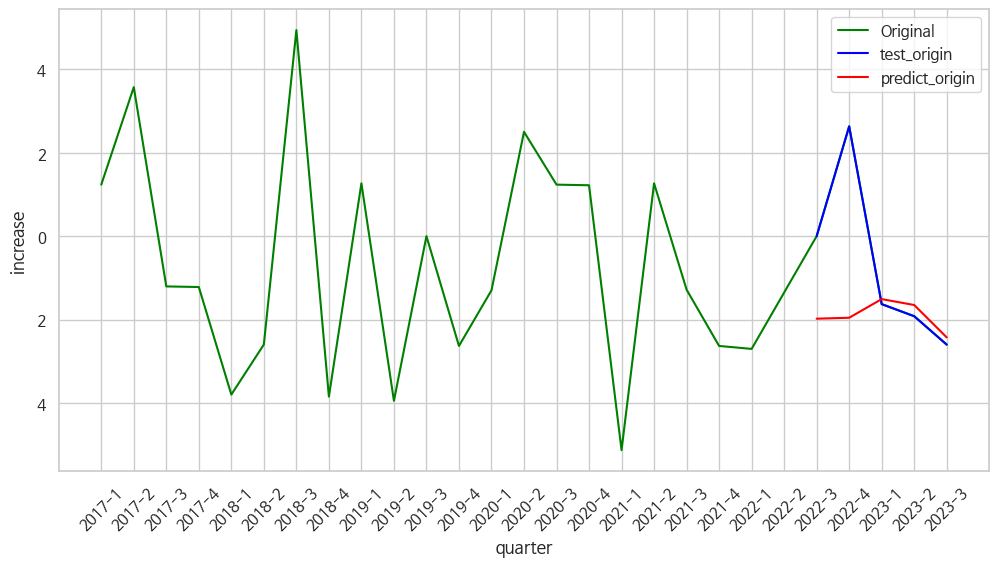

In [468]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_conv['분기'], sin_conv['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [469]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     1.200666
std      2.113522
min     -0.268413
25%     -0.174042
50%     -0.120244
75%      1.978652
max      4.587377
dtype: float64

In [470]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,3,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 26ms/step
[[0.19569595]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -3.158236503601074 


### 추가

In [471]:
sin_conv.loc[27] = ['2023-4', '편의점', sales, growth, increase, marketability]

<ipython-input-471-ce9960c7d63a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_conv.loc[27] = ['2023-4', '편의점', sales, growth, increase, marketability]


In [472]:
final_sin_conv = sin_conv
final_sin_conv

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,편의점,1.509017e+10,1.000000,1.234568,1.323951e+05
1,2017-2,편의점,1.656823e+10,1.097949,3.571429,-1.083172e+07
2,2017-3,편의점,1.731081e+10,1.044820,-1.204819,-7.397627e+06
3,2017-4,편의점,1.567411e+10,0.905452,-1.219512,-3.795571e+06
4,2018-1,편의점,1.478183e+10,0.943073,-3.797468,8.262468e+05
5,2018-2,편의점,1.646501e+10,1.113868,-2.597403,-2.677290e+06
6,2018-3,편의점,1.643938e+10,0.998443,4.938272,-1.167881e+07
7,2018-4,편의점,1.543388e+10,0.938836,-3.846154,-6.290746e+06
8,2019-1,편의점,1.237611e+10,0.801880,1.265823,-8.412306e+06
9,2019-2,편의점,1.327310e+10,1.072477,-3.947368,-2.017622e+06


## 최종결과

In [473]:
### X / y 데이터 생성
X = sin_conv[['성장성', '시장성', '순점포증감률']]
y = sin_conv.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  1.323951e+05  1.234568
1   1.097949 -1.083172e+07  3.571429
2   1.044820 -7.397627e+06 -1.204819
3   0.905452 -3.795571e+06 -1.219512
4   0.943073  8.262468e+05 -3.797468
5   1.113868 -2.677290e+06 -2.597403
6   0.998443 -1.167881e+07  4.938272
7   0.938836 -6.290746e+06 -3.846154
8   0.801880 -8.412306e+06  1.265823
9   1.072477 -2.017622e+06 -3.947368
10  1.020857 -1.232886e+07  0.000000
11  1.126286  8.366798e+06 -2.631579
12  0.830779 -1.331752e+06 -1.298701
13  1.041332 -7.169836e+06  2.500000
14  1.067797 -4.450322e+06  1.234568
15  0.955822 -6.893093e+06  1.219512
16  0.887361 -1.055772e+06 -5.128205
17  1.129111  1.845858e+06  1.265823
18  0.990444 -7.321959e+05 -1.282051
19  1.083713  1.514778e+07 -2.631579
20  0.942607  1.985382e+07 -2.702703
21  1.058867  1.800774e+07 -1.351351
22  1.090826  2.645425e+07  0.000000
23  0.983232  2.564779e+07  2.631579
24  0.910432 -4.205730e+06 -1.629235
25  0.915487 -4.281917e+06 -1.919210
2

In [474]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (28, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (28, 1)


In [475]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 3)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 3)
print(X_last_test)

X_data 데이터의 모양 : (25, 3, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.34717583 0.20748582 0.3187804 ]
 [0.30997131 0.18044144 0.2511069 ]
 [0.23899705 0.1386938  0.19569594]]


In [476]:
# 평가용 데이터 크기 설정
TEST_SIZE = 5

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 3, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (20, 3, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 3, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [477]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00005))

# 모델 확인
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_73 (LSTM)              (None, 32)                12416     
                                                                 
 dense_36 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [478]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=300,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.3071
Epoch 1: val_loss improved from inf to 0.19281, saving model to stock_model.h5
1/1 [==============================] - 3s 3s/step - loss: 0.3071 - val_loss: 0.1928
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.3063
Epoch 2: val_loss improved from 0.19281 to 0.19209, saving model to stock_model.h5
1/1 [==============================] - 0s 74ms/step - loss: 0.3063 - val_loss: 0.1921
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.3054
Epoch 3: val_loss improved from 0.19209 to 0.19137, saving model to stock_model.h5
1/1 [==============================] - 0s 72ms/step - loss: 0.3054 - val_loss: 0.1914
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.3046
Epoch 4: val_loss improved from 0.19137 to 0.19065, saving model to stock_model.h5
1/1 [==============================] - 0s 73ms/step - loss: 0.3046 - val_loss: 0.1907
Epoch 5/300
1/1 [=================

In [479]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 591ms/step
[[0.3145013 ]
 [0.37216717]
 [0.3612684 ]
 [0.3016335 ]
 [0.23898157]]


In [480]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_conv.iloc[-5:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.664163,0.314501
2023-1,0.234398,0.372167
2023-2,0.288492,0.361268
2023-3,0.248216,0.301634
2023-4,0.225232,0.238982


In [481]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_conv.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_conv의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.664163,0.314501,1.551284e+10,1.364086e+10,1.871980e+09
2023-1,0.234398,0.372167,1.321202e+10,1.394959e+10,-7.375729e+08
2023-2,0.288492,0.361268,1.350162e+10,1.389124e+10,-3.896238e+08
2023-3,0.248216,0.301634,1.328599e+10,1.357197e+10,-2.859817e+08
2023-4,0.225232,0.238982,1.316294e+10,1.323655e+10,-7.360922e+07


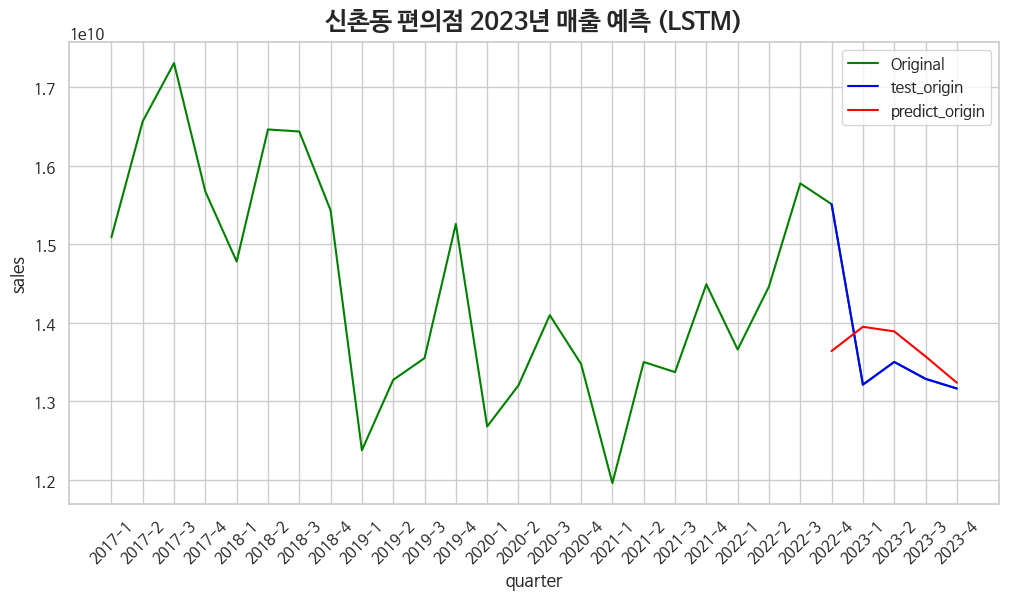

In [482]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.title('신촌동 편의점 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)

plt.plot(sin_conv['분기'], sin_conv['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()